In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv')   ## We will be merging the data files to training data
df_train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [3]:
df_train.shape

(78369, 5)

In [4]:
df_train['customer_id'].nunique() ## we have 1428 customers in training data

1428

In [5]:
df_cust_demo=pd.read_csv('customer_demographics.csv')
df_cust_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [6]:
df_cust_demo.drop(['marital_status','no_of_children'],axis=1,inplace=True) 
## as these variables had around 50% of null values
## imputation won't make sense for these columns so we removed the columns

In [7]:
df_cust_demo.head()

,customer_id,age_range,rented,family_size,income_bracket
0,1,70+,0,2,4
1,6,46-55,0,2,5
2,7,26-35,0,3,3
3,8,26-35,0,4,6
4,10,46-55,0,1,5


In [8]:
df_campaign=pd.read_csv('campaign_data1.csv')
df_campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaigning_days
0,24,Y,21-10-2013,20-12-2013,60
1,25,Y,21-10-2013,22-11-2013,32
2,20,Y,07-09-2013,16-11-2013,70
3,23,Y,08-10-2013,15-11-2013,38
4,21,Y,16-09-2013,18-10-2013,32


In [9]:
df_campaign.shape

(28, 5)

In [10]:
df_campaign['campaign_id'].nunique()
## we have 28 campaign's done so we will take these data and will merege into our main dataset

28

In [11]:
df_item=pd.read_csv('item_data.csv')
df_item.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [12]:
df_coupons=pd.read_csv('coupon_item_mapping.csv')
df_coupons.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [13]:
## we have merged coupon item mapping data and item data as item data has uniques 
df_item_coupon=pd.merge(df_item,df_coupons,how='right',on='item_id')
df_item_coupon.head()  

,item_id,brand,brand_type,category,coupon_id
0,37,56,Local,Grocery,105
1,75,56,Local,Grocery,107
2,76,209,Established,Grocery,494
3,77,278,Established,Grocery,522
4,77,278,Established,Grocery,518


In [14]:
df_item_coupon.shape

(92663, 5)

In [15]:
df_item_coupon.isnull().sum()

item_id       0
brand         0
brand_type    0
category      0
coupon_id     0
dtype: int64

In [16]:
df_item_coupon.drop_duplicates(keep='first',inplace=True) ## no duplicates has found

df_item_coupon.shape

(92663, 5)

In [17]:
df_cust_trac=pd.read_csv('customer_transaction_data.csv')
df_cust_trac.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [18]:
## we are doing future engineering here
### from customer transaction we will create two data sets we are
## 1. item_data: which has unique item id and the aggregates of selling price quantity discounts details of each item
## 2. customer_data: which has uniques customer transaction details and the aggregates of selling price quantity discounts details for each customer

In [19]:
## 1. item_data:
df_cust_trac['Trans_count']=1

In [20]:
df_cust_trac['Coupon_count']=df_cust_trac.coupon_discount.apply(lambda x:0 if x==0 else 1)

In [21]:
df_cust_trac.head()


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,Trans_count,Coupon_count
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,1,0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,1,0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0,1,0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,1,0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0,1,0


In [22]:
agg_trans= pd.pivot_table(df_cust_trac, index = 'item_id',
                                    values = ['customer_id','quantity','selling_price','other_discount',
                                              'coupon_discount','Trans_count','Coupon_count'],
                                    aggfunc={'customer_id':lambda x:len(set(x)),
                                             'quantity':np.mean,
                                             'selling_price':np.mean,
                                             'other_discount':np.mean,
                                             'coupon_discount':np.mean,
                                             'Trans_count':np.sum,
                                             'Coupon_count':np.sum})

In [23]:

columns_upd = {'customer_id':'customer_count','quantity':'avg_order_quantity',
            'selling_price':'avg_price','other_discount':'avg_oth_dis',
            'coupon_discount':'avg_coup_dis','Trans_count':'Trans_count','Coupon_count':'sum_coup_count'}
agg_trans.rename(columns=columns_upd, inplace = True)

In [24]:
print(agg_trans.shape)


(74063, 7)


In [25]:
agg_trans.head(5) ## here we got item wise aggregate values of coupons discounts, quantity and transaction count of that item

,sum_coup_count,Trans_count,avg_coup_dis,customer_count,avg_oth_dis,avg_order_quantity,avg_price
item_id,,,,,,,
1,0,2,0.0,2,0.0,1.0,124.31
2,0,1,0.0,1,0.0,1.0,35.26
3,0,1,0.0,1,0.0,1.0,56.64
4,0,1,0.0,1,0.0,1.0,54.85
5,0,1,0.0,1,0.0,1.0,81.57


In [26]:
# to know sum of coupon discout per item (avg coupon discont  per item * count of transaction)
agg_trans['sum_coup_dis'] = agg_trans['avg_coup_dis']*agg_trans['Trans_count']

# to know sum of other discout per item (avg other discont  per item * count of transaction)
agg_trans['sum_oth_dis'] = agg_trans['avg_oth_dis']*agg_trans['Trans_count']

# to know sum of order quantity per item (avg order quantity discont item per item * count of transaction)
agg_trans['sum_order_quantity']= agg_trans['avg_order_quantity']*agg_trans['Trans_count']

# to know sum of total coupon discout per item (avg coupon discont item per item * count of transaction)
agg_trans['sum_total_dis'] = agg_trans['sum_coup_dis'] +agg_trans['Trans_count']

# to know avg total discout per item (avg coupon discont item per item * count of transaction)
agg_trans['avg_total_dis'] = agg_trans['avg_coup_dis'] +agg_trans['Trans_count']

agg_trans.head()
### we have added new features to get the total coupons discounts, quantity and transaction count of that item

,sum_coup_count,Trans_count,avg_coup_dis,customer_count,avg_oth_dis,avg_order_quantity,avg_price,sum_coup_dis,sum_oth_dis,sum_order_quantity,sum_total_dis,avg_total_dis
item_id,,,,,,,,,,,,
1,0,2,0.0,2,0.0,1.0,124.31,0.0,0.0,2.0,2.0,2.0
2,0,1,0.0,1,0.0,1.0,35.26,0.0,0.0,1.0,1.0,1.0
3,0,1,0.0,1,0.0,1.0,56.64,0.0,0.0,1.0,1.0,1.0
4,0,1,0.0,1,0.0,1.0,54.85,0.0,0.0,1.0,1.0,1.0
5,0,1,0.0,1,0.0,1.0,81.57,0.0,0.0,1.0,1.0,1.0


In [27]:
# merging agg_transaction data with merged items coupon data
trans_item_coup=pd.merge(agg_trans,df_item_coupon,on='item_id',how='left')
print(trans_item_coup.shape)

(130432, 17)


In [28]:
trans_item_coup.head(5)

,item_id,sum_coup_count,Trans_count,avg_coup_dis,customer_count,avg_oth_dis,avg_order_quantity,avg_price,sum_coup_dis,sum_oth_dis,sum_order_quantity,sum_total_dis,avg_total_dis,brand,brand_type,category,coupon_id
0,1,0,2,0.0,2,0.0,1.0,124.31,0.0,0.0,2.0,2.0,2.0,1.0,Established,Grocery,22.0
1,1,0,2,0.0,2,0.0,1.0,124.31,0.0,0.0,2.0,2.0,2.0,1.0,Established,Grocery,31.0
2,2,0,1,0.0,1,0.0,1.0,35.26,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,3,0,1,0.0,1,0.0,1.0,56.64,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,4,0,1,0.0,1,0.0,1.0,54.85,0.0,0.0,1.0,1.0,1.0,56.0,Local,Grocery,166.0


In [29]:
trans_item_coup.drop(['brand_type','category'],1,inplace=True)

In [30]:
trans_coup = pd.pivot_table(trans_item_coup, index ='coupon_id',
                                             values=['item_id', 'Trans_count', 'sum_coup_count', 'avg_coup_dis',
                                                     'customer_count', 'avg_oth_dis', 'avg_order_quantity', 'avg_price',
                                                     'sum_coup_dis', 'sum_oth_dis', 'sum_order_quantity',
                                                     'sum_total_dis', 'avg_total_dis', 'brand'],
                                            aggfunc={'item_id':lambda x: len(set(x)),
                                                     'Trans_count':np.sum,
                                                     'sum_coup_count':np.sum,
                                                     'avg_coup_dis':np.mean,
                                                     'customer_count':np.sum,
                                                     'avg_oth_dis':np.mean,
                                                     'avg_order_quantity':np.mean,
                                                     'avg_price':np.mean,
                                                     'sum_coup_dis':np.sum,
                                                     'sum_oth_dis':np.sum,
                                                     'sum_order_quantity':np.sum,
                                                     'sum_total_dis':np.sum,
                                                     'avg_total_dis':np.mean,
                                                     'brand':lambda x: len(set(x))})


In [31]:
cols_upd= { 'item_id': 'count_items',
            'brand': 'count_brands'}
trans_coup.rename(columns = cols_upd, inplace = True)

In [32]:
trans_coup.head(5)

,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis
coupon_id,,,,,,,,,,,,,,
1.0,826,-1.321524,1.221644,-25.273218,100.195701,19.857963,3,577,39,35,-1526.31,1034.0,-24468.37,-700.31
2.0,81,0.000000,1.137500,-23.314062,114.354437,40.500000,1,30,2,0,0.00,103.0,-1478.75,81.00
3.0,212,-2.747358,1.121525,-17.543797,129.981640,9.723230,2,146,17,15,-578.81,248.0,-4952.62,-366.81
4.0,676,-1.485152,1.020872,-37.411408,178.722897,26.681515,1,536,24,44,-881.59,702.0,-26804.05,-205.59
5.0,44,0.000000,1.000000,-27.265786,376.704214,6.285714,1,42,7,0,0.00,44.0,-1228.88,44.00


In [33]:
## here we have ended up getting for each coupon we got no. of transactions, no. of customers bought that item and there respective aggregates

In [34]:
# merging train data with item coupons transaction data 
df_train_trans=pd.merge(df_train,trans_coup,on='coupon_id',how='left')
print(df_train_trans.shape)


(78369, 19)


In [35]:
df_train_trans.head(5)

,id,campaign_id,coupon_id,customer_id,redemption_status,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis
0,1,13,27,1053,0,3713,-1.241694,1.169768,-51.732305,84.478583,28.462306,2,2403,125,191,-5349.93,4661.0,-225584.38,-1636.93
1,2,13,116,48,0,75,0.000000,1.050926,-10.661343,63.833519,25.000000,1,61,3,0,0.00,86.0,-684.27,75.00
2,6,9,635,205,0,142,-2.987321,1.353802,-142.498493,332.128380,-0.867918,1,118,67,15,-605.54,202.0,-23566.35,-463.54
3,7,13,644,1050,0,39,-4.452500,1.110390,-5.010601,94.261640,5.297500,1,14,4,1,-17.81,47.0,-309.91,21.19
4,9,8,1017,1489,0,1420,-0.198055,1.071044,-33.629121,181.621631,44.176945,1,874,32,23,-569.92,1610.0,-54950.74,850.08


In [36]:
## 2. customer_data:

In [37]:
trans1= pd.pivot_table(df_cust_trac, index = 'customer_id',
                                 values =['item_id', 'quantity', 'selling_price','other_discount',
                                          'coupon_discount','Trans_count','Coupon_count'],
                                aggfunc={'item_id':len, 
                                         'quantity':np.mean,
                                         'selling_price':np.mean,
                                         'other_discount':np.mean,
                                         'coupon_discount':np.mean,
                                         'Coupon_count':np.mean})

In [38]:
new_cols={'item_id':'count_items_cust',
          'quantity':'avg_quantity_cust',
          'selling_price':'avg_price_cust',
          'other_discount':'avg_oth_disc_cust',
          'coupon_discount':'avg_coup_disc_cust',
          'Coupon_count':'avg_coup_count_cust'}
trans1.rename(columns=new_cols, inplace= True)

In [39]:
trans1.head()

,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust
customer_id,,,,,,
1,0.074427,-2.019876,1048,-16.250382,1.170802,94.001842
2,0.009547,-0.595084,419,-16.830430,1.131265,102.864033
3,0.075177,-3.091546,705,-22.714227,11.578723,103.617404
4,0.004545,-0.404773,220,-13.305409,1.272727,154.423727
5,0.002525,-0.114684,792,-13.657917,117.869949,130.827146


In [40]:
trans1['sum_quantity_cust']=trans1['count_items_cust']*trans1['avg_quantity_cust']
trans1['sum_price_cust']=trans1['count_items_cust']*trans1['avg_price_cust']
trans1['sum_oth_disc_cust']=trans1['count_items_cust']*trans1['avg_oth_disc_cust']
trans1['sum_coupp_disc_cust']=trans1['count_items_cust']*trans1['avg_coup_disc_cust']
trans1['count_coup_used_cust']=trans1['count_items_cust']*trans1['avg_coup_count_cust']

print(trans1.shape)

(1582, 11)


In [41]:
trans1.head()

,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust
customer_id,,,,,,,,,,,
1,0.074427,-2.019876,1048,-16.250382,1.170802,94.001842,1227.0,98513.93,-17030.40,-2116.83,78.0
2,0.009547,-0.595084,419,-16.830430,1.131265,102.864033,474.0,43100.03,-7051.95,-249.34,4.0
3,0.075177,-3.091546,705,-22.714227,11.578723,103.617404,8163.0,73050.27,-16013.53,-2179.54,53.0
4,0.004545,-0.404773,220,-13.305409,1.272727,154.423727,280.0,33973.22,-2927.19,-89.05,1.0
5,0.002525,-0.114684,792,-13.657917,117.869949,130.827146,93353.0,103615.10,-10817.07,-90.83,2.0


In [42]:
## Here we have got customers data which has the the aggregate details of quantity, discounts details

In [43]:
# merging new transaction data with customer demographic data 
trans_demog=pd.merge(trans1,df_cust_demo,on='customer_id',how='left')

In [44]:
trans_demog.shape

(1582, 16)

In [45]:
trans_demog.head()

,customer_id,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,age_range,rented,family_size,income_bracket
0,1,0.074427,-2.019876,1048,-16.250382,1.170802,94.001842,1227.0,98513.93,-17030.40,-2116.83,78.0,70+,0.0,2,4.0
1,2,0.009547,-0.595084,419,-16.830430,1.131265,102.864033,474.0,43100.03,-7051.95,-249.34,4.0,NaN,NaN,NaN,NaN
2,3,0.075177,-3.091546,705,-22.714227,11.578723,103.617404,8163.0,73050.27,-16013.53,-2179.54,53.0,NaN,NaN,NaN,NaN
3,4,0.004545,-0.404773,220,-13.305409,1.272727,154.423727,280.0,33973.22,-2927.19,-89.05,1.0,NaN,NaN,NaN,NaN
4,5,0.002525,-0.114684,792,-13.657917,117.869949,130.827146,93353.0,103615.10,-10817.07,-90.83,2.0,NaN,NaN,NaN,NaN


In [46]:
# merging transaction demographic data with train item coupon aggregte transaction data 
final_tr=pd.merge(df_train_trans,trans_demog,on='customer_id',how='left')
print(final_tr.shape)

(78369, 34)


In [47]:
final_tr.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,...,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,age_range,rented,family_size,income_bracket
0,1,13,27,1053,0,3713,-1.241694,1.169768,-51.732305,84.478583,...,184.260484,105551.0,57120.75,-10282.37,-89.05,1.0,46-55,0.0,1,5.0
1,2,13,116,48,0,75,0.000000,1.050926,-10.661343,63.833519,...,234.247013,12143.0,90185.10,-10664.18,-1237.79,12.0,36-45,0.0,2,3.0
2,6,9,635,205,0,142,-2.987321,1.353802,-142.498493,332.128380,...,121.094495,1351.0,117461.66,-17261.79,-2145.72,85.0,46-55,0.0,2,7.0
3,7,13,644,1050,0,39,-4.452500,1.110390,-5.010601,94.261640,...,98.276034,306.0,23291.42,-3947.37,-178.10,2.0,NaN,NaN,NaN,NaN
4,9,8,1017,1489,0,1420,-0.198055,1.071044,-33.629121,181.621631,...,120.636103,139063.0,67797.49,-11534.90,-265.01,10.0,46-55,0.0,2,3.0


In [48]:
# merging train item coupon agg transaction customer demographic data with campaign data
df_final=pd.merge(final_tr,df_campaign,on='campaign_id',how='left')
print(df_final.shape)

(78369, 38)


In [49]:
df_final.head(5)

,id,campaign_id,coupon_id,customer_id,redemption_status,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,...,sum_coupp_disc_cust,count_coup_used_cust,age_range,rented,family_size,income_bracket,campaign_type,start_date,end_date,campaigning_days
0,1,13,27,1053,0,3713,-1.241694,1.169768,-51.732305,84.478583,...,-89.05,1.0,46-55,0.0,1,5.0,X,19-05-2013,05-07-2013,47
1,2,13,116,48,0,75,0.000000,1.050926,-10.661343,63.833519,...,-1237.79,12.0,36-45,0.0,2,3.0,X,19-05-2013,05-07-2013,47
2,6,9,635,205,0,142,-2.987321,1.353802,-142.498493,332.128380,...,-2145.72,85.0,46-55,0.0,2,7.0,Y,11-03-2013,12-04-2013,32
3,7,13,644,1050,0,39,-4.452500,1.110390,-5.010601,94.261640,...,-178.10,2.0,NaN,NaN,NaN,NaN,X,19-05-2013,05-07-2013,47
4,9,8,1017,1489,0,1420,-0.198055,1.071044,-33.629121,181.621631,...,-265.01,10.0,46-55,0.0,2,3.0,X,16-02-2013,05-04-2013,48


In [50]:
df_final.drop_duplicates(keep='first',inplace=True)


In [51]:
df_final.shape

(78369, 38)

In [52]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    78369 non-null  int64  
 1   campaign_id           78369 non-null  int64  
 2   coupon_id             78369 non-null  int64  
 3   customer_id           78369 non-null  int64  
 4   redemption_status     78369 non-null  int64  
 5   Trans_count           78369 non-null  int64  
 6   avg_coup_dis          78369 non-null  float64
 7   avg_order_quantity    78369 non-null  float64
 8   avg_oth_dis           78369 non-null  float64
 9   avg_price             78369 non-null  float64
 10  avg_total_dis         78369 non-null  float64
 11  count_brands          78369 non-null  int64  
 12  customer_count        78369 non-null  int64  
 13  count_items           78369 non-null  int64  
 14  sum_coup_count        78369 non-null  int64  
 15  sum_coup_dis       

In [53]:
df_final['campaign_type'].value_counts()

X    57684
Y    20685
Name: campaign_type, dtype: int64

In [54]:
df_final['campaign_type'].value_counts()/len(df_final)*100

X    73.605635
Y    26.394365
Name: campaign_type, dtype: float64

In [55]:
df_final.isnull().sum()

id                          0
campaign_id                 0
coupon_id                   0
customer_id                 0
redemption_status           0
Trans_count                 0
avg_coup_dis                0
avg_order_quantity          0
avg_oth_dis                 0
avg_price                   0
avg_total_dis               0
count_brands                0
customer_count              0
count_items                 0
sum_coup_count              0
sum_coup_dis                0
sum_order_quantity          0
sum_oth_dis                 0
sum_total_dis               0
avg_coup_count_cust         0
avg_coup_disc_cust          0
count_items_cust            0
avg_oth_disc_cust           0
avg_quantity_cust           0
avg_price_cust              0
sum_quantity_cust           0
sum_price_cust              0
sum_oth_disc_cust           0
sum_coupp_disc_cust         0
count_coup_used_cust        0
age_range               34708
rented                  34708
family_size             34708
income_bra

In [56]:
df_final.isnull().sum()/len(df_final)*100

id                       0.00000
campaign_id              0.00000
coupon_id                0.00000
customer_id              0.00000
redemption_status        0.00000
Trans_count              0.00000
avg_coup_dis             0.00000
avg_order_quantity       0.00000
avg_oth_dis              0.00000
avg_price                0.00000
avg_total_dis            0.00000
count_brands             0.00000
customer_count           0.00000
count_items              0.00000
sum_coup_count           0.00000
sum_coup_dis             0.00000
sum_order_quantity       0.00000
sum_oth_dis              0.00000
sum_total_dis            0.00000
avg_coup_count_cust      0.00000
avg_coup_disc_cust       0.00000
count_items_cust         0.00000
avg_oth_disc_cust        0.00000
avg_quantity_cust        0.00000
avg_price_cust           0.00000
sum_quantity_cust        0.00000
sum_price_cust           0.00000
sum_oth_disc_cust        0.00000
sum_coupp_disc_cust      0.00000
count_coup_used_cust     0.00000
age_range 

In [57]:
## we are removing columns which are not neccesary for our analysis

In [58]:
df_final.drop(['id','start_date','end_date'],axis=1,inplace=True)

In [59]:
df_final.shape

(78369, 35)

In [60]:
## as we know we have null values we will try to impute them

In [61]:
## we are creating new dataset which doen't have null values to know there percentages

df_without_null=df_final.dropna()

df_without_null.shape

(43661, 35)

In [62]:
df_without_null['rented'].value_counts()/len(df_without_null)*100

0.0    94.262614
1.0     5.737386
Name: rented, dtype: float64

<AxesSubplot:xlabel='rented', ylabel='count'>

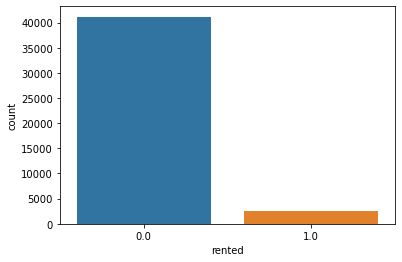

In [63]:

sns.countplot(df_without_null['rented'])

In [64]:
df_without_null['rented'].std()

0.2325582439776735

In [65]:
## as we can see most of them are not rented and the standard deviation of the variable is nearly zero 
## so we will drop that rented column from our real dataset

In [66]:
df_final.drop(['rented'],axis=1,inplace=True)

df_final.head(2)

,campaign_id,coupon_id,customer_id,redemption_status,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,...,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,age_range,family_size,income_bracket,campaign_type,campaigning_days
0,13,27,1053,0,3713,-1.241694,1.169768,-51.732305,84.478583,28.462306,...,105551.0,57120.75,-10282.37,-89.05,1.0,46-55,1,5.0,X,47
1,13,116,48,0,75,0.000000,1.050926,-10.661343,63.833519,25.000000,...,12143.0,90185.10,-10664.18,-1237.79,12.0,36-45,2,3.0,X,47


In [67]:
df_without_null['age_range'].value_counts()/len(df_without_null)*100

46-55    34.708321
36-45    25.675088
26-35    18.377957
56-70     8.527061
70+       7.086416
18-25     5.625157
Name: age_range, dtype: float64

In [68]:
## we have done created new values of subgroups for better imputation of our data

df_final['age_range']=df_final['age_range'].map({'18-25':'Young Adults',
                                                 '26-35':'Young Adults',
                                                 '36-45':'Middle Aged Adults',
                                                 '46-55':'Old Aged Adults',
                                                '56-70':'Old Aged Adults',
                                                '70+':'Senior Citizens'})

In [69]:
df_final['age_range'].value_counts()/len(df_final)*100

Old Aged Adults       24.087330
Middle Aged Adults    14.304125
Young Adults          13.372635
Senior Citizens        3.947990
Name: age_range, dtype: float64

In [70]:
df_without_null=df_final.dropna()

In [71]:
## we have the percentages of age ranges in without  null value data
df_without_null['age_range'].value_counts()/len(df_without_null)*100

Old Aged Adults       43.235382
Middle Aged Adults    25.675088
Young Adults          24.003115
Senior Citizens        7.086416
Name: age_range, dtype: float64

In [72]:
## now we will impute the null value to the age range to our final data

df_final['age_range'] =df_final['age_range'].fillna(pd.Series(np.random.choice(['Old Aged Adults','Middle Aged Adults','Young Adults','Senior Citizens'],
                                  p=[0.40,0.28,0.26,0.06], size=len(df_final))))

In [73]:
df_final['age_range'].isnull().sum() ## we have imputed the null values here

0

In [74]:
df_final['age_range'].value_counts()/len(df_final)*100

Old Aged Adults       41.749927
Middle Aged Adults    26.866491
Young Adults          24.827419
Senior Citizens        6.556164
Name: age_range, dtype: float64

In [75]:
df_without_null['family_size'].value_counts()/len(df_without_null)*100

2     38.679829
1     31.176565
3     14.353771
5+     8.600353
4      7.189483
Name: family_size, dtype: float64

In [76]:
df_final['family_size'] =df_final['family_size'].fillna(pd.Series(np.random.choice(['2','1','3','4','5+'],
                                  p=[0.38,0.28,0.15,0.1,0.09], size=len(df_final))))

In [77]:
df_final['family_size'].isnull().sum() ## we have imputed the null values here


0

In [78]:
df_without_null['income_bracket'].value_counts()/len(df_without_null)*100

5.0     25.278853
4.0     20.047640
6.0     11.119764
2.0      8.914134
3.0      8.891230
1.0      7.915531
8.0      5.425895
9.0      4.624264
7.0      4.189093
12.0     1.823137
10.0     1.174962
11.0     0.595497
Name: income_bracket, dtype: float64

In [79]:
df_final['income_bracket'] =df_final['income_bracket'].fillna(pd.Series(np.random.choice([5.0,4.0,6.0,1.0,3.0,8.0,2.0,7.0,9.0,12.0,10.0,11.0],
                                  p=[0.29,0.18,0.12,0.08,0.06,0.06,0.055,0.05,0.048,0.019,0.014,0.024], size=len(df_final))))


In [80]:
def cat_income_bracket(income_bracket):
    if income_bracket <= 3:
        return 'lower'
    elif income_bracket <= 5:
        return 'lower middle'
    elif income_bracket <= 8:
        return 'upper middle'
    else:
        return 'upper'


df_final['income_bracket']=df_final['income_bracket'].apply(cat_income_bracket)

In [81]:
df_final['income_bracket'].value_counts()/len(df_final)*100


lower middle    46.230014
lower           22.785795
upper middle    21.690975
upper            9.293215
Name: income_bracket, dtype: float64

In [82]:
df_final.isnull().sum()

campaign_id             0
coupon_id               0
customer_id             0
redemption_status       0
Trans_count             0
avg_coup_dis            0
avg_order_quantity      0
avg_oth_dis             0
avg_price               0
avg_total_dis           0
count_brands            0
customer_count          0
count_items             0
sum_coup_count          0
sum_coup_dis            0
sum_order_quantity      0
sum_oth_dis             0
sum_total_dis           0
avg_coup_count_cust     0
avg_coup_disc_cust      0
count_items_cust        0
avg_oth_disc_cust       0
avg_quantity_cust       0
avg_price_cust          0
sum_quantity_cust       0
sum_price_cust          0
sum_oth_disc_cust       0
sum_coupp_disc_cust     0
count_coup_used_cust    0
age_range               0
family_size             0
income_bracket          0
campaign_type           0
campaigning_days        0
dtype: int64

In [83]:
### We have imputed the null values by logical imputation

In [84]:
df_final.shape

(78369, 34)

In [85]:
df_final.head(5)

,campaign_id,coupon_id,customer_id,redemption_status,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,...,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,age_range,family_size,income_bracket,campaign_type,campaigning_days
0,13,27,1053,0,3713,-1.241694,1.169768,-51.732305,84.478583,28.462306,...,105551.0,57120.75,-10282.37,-89.05,1.0,Old Aged Adults,1,lower middle,X,47
1,13,116,48,0,75,0.000000,1.050926,-10.661343,63.833519,25.000000,...,12143.0,90185.10,-10664.18,-1237.79,12.0,Middle Aged Adults,2,lower,X,47
2,9,635,205,0,142,-2.987321,1.353802,-142.498493,332.128380,-0.867918,...,1351.0,117461.66,-17261.79,-2145.72,85.0,Old Aged Adults,2,upper middle,Y,32
3,13,644,1050,0,39,-4.452500,1.110390,-5.010601,94.261640,5.297500,...,306.0,23291.42,-3947.37,-178.10,2.0,Young Adults,2,lower middle,X,47
4,8,1017,1489,0,1420,-0.198055,1.071044,-33.629121,181.621631,44.176945,...,139063.0,67797.49,-11534.90,-265.01,10.0,Old Aged Adults,2,lower,X,48


In [86]:
df_final['coupon_id'].value_counts()/len(df_final)*100

705     0.727328
470     0.570379
691     0.516786
468     0.467021
1043    0.455537
          ...   
404     0.015312
398     0.015312
389     0.015312
823     0.015312
1091    0.015312
Name: coupon_id, Length: 866, dtype: float64

### Univarient Analysis

In [87]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   campaign_id           78369 non-null  int64  
 1   coupon_id             78369 non-null  int64  
 2   customer_id           78369 non-null  int64  
 3   redemption_status     78369 non-null  int64  
 4   Trans_count           78369 non-null  int64  
 5   avg_coup_dis          78369 non-null  float64
 6   avg_order_quantity    78369 non-null  float64
 7   avg_oth_dis           78369 non-null  float64
 8   avg_price             78369 non-null  float64
 9   avg_total_dis         78369 non-null  float64
 10  count_brands          78369 non-null  int64  
 11  customer_count        78369 non-null  int64  
 12  count_items           78369 non-null  int64  
 13  sum_coup_count        78369 non-null  int64  
 14  sum_coup_dis          78369 non-null  float64
 15  sum_order_quantity 

In [88]:
## As datatypes of variables may have int but in actual they are not integers and 
## we also have id data where it is unique so doing analysis on them will make no sense 
## here we will take actual numerical and categorical variables and we will perform aUnivarient analysis on them


In [89]:
df_final.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'Trans_count', 'avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands', 'customer_count',
       'count_items', 'sum_coup_count', 'sum_coup_dis', 'sum_order_quantity',
       'sum_oth_dis', 'sum_total_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust', 'age_range', 'family_size', 'income_bracket',
       'campaign_type', 'campaigning_days'],
      dtype='object')

In [90]:
df_num=df_final[['Trans_count','avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands', 'customer_count',
       'count_items', 'sum_coup_count', 'sum_coup_dis', 'sum_order_quantity',
       'sum_oth_dis', 'sum_total_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust','campaigning_days']]
df_num.head()

,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,...,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days
0,3713,-1.241694,1.169768,-51.732305,84.478583,28.462306,2,2403,125,191,...,310,-33.168935,340.487097,184.260484,105551.0,57120.75,-10282.37,-89.05,1.0,47
1,75,0.000000,1.050926,-10.661343,63.833519,25.000000,1,61,3,0,...,385,-27.699169,31.540260,234.247013,12143.0,90185.10,-10664.18,-1237.79,12.0,47
2,142,-2.987321,1.353802,-142.498493,332.128380,-0.867918,1,118,67,15,...,970,-17.795660,1.392784,121.094495,1351.0,117461.66,-17261.79,-2145.72,85.0,32
3,39,-4.452500,1.110390,-5.010601,94.261640,5.297500,1,14,4,1,...,237,-16.655570,1.291139,98.276034,306.0,23291.42,-3947.37,-178.10,2.0,47
4,1420,-0.198055,1.071044,-33.629121,181.621631,44.176945,1,874,32,23,...,562,-20.524733,247.443060,120.636103,139063.0,67797.49,-11534.90,-265.01,10.0,48


In [91]:
df_num.describe()

,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,...,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days
count,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,...,78369.000000,78369.000000,78369.000000,78369.000000,7.836900e+04,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000
mean,2031.808802,-2.265920,1.173147,-24.627777,153.914308,27.795401,6.880922,1173.947926,81.919216,42.509270,...,1032.534752,-18.273669,128.055506,116.003809,1.412794e+05,119180.270731,-18440.669741,-670.316295,18.391430,44.771325
std,11941.508175,5.814932,0.264655,26.862557,138.702717,28.420784,64.715613,6832.645414,604.963314,208.578869,...,658.065148,8.666128,216.197239,31.576526,2.414470e+05,81901.616150,13045.169905,1275.994181,38.662831,6.145676
min,1.000000,-71.240000,1.000000,-733.130000,23.616503,-70.240000,1.000000,1.000000,1.000000,0.000000,...,83.000000,-191.188099,1.042453,47.739190,8.800000e+01,8338.540000,-101428.310000,-11937.800000,0.000000,32.000000
25%,86.000000,-2.101764,1.032746,-32.240629,85.108789,7.740139,1.000000,56.000000,5.000000,0.000000,...,557.000000,-20.866231,1.403756,95.877243,1.593000e+03,59205.590000,-23509.230000,-719.510000,1.000000,46.000000
50%,279.000000,-0.608013,1.095333,-17.999941,113.166224,22.203490,1.000000,168.000000,12.000000,5.000000,...,884.000000,-16.724106,39.755390,111.057371,3.164100e+04,98840.740000,-15290.490000,-224.400000,5.000000,47.000000
75%,857.000000,0.000000,1.202614,-9.455043,173.600912,41.191230,1.000000,532.000000,30.000000,23.000000,...,1335.000000,-13.897148,190.594817,130.539012,1.847090e+05,155596.980000,-9294.290000,-39.180000,17.000000,48.000000
max,158788.000000,0.000000,4.096092,0.000000,1275.897712,253.428571,1187.000000,89758.000000,11811.000000,2661.000000,...,4522.000000,-4.674406,3490.058667,387.717920,2.617544e+06,583638.780000,-734.800000,0.000000,430.000000,63.000000


In [92]:
df_cat=df_final[['redemption_status','age_range','campaign_type','income_bracket','family_size']]

df_cat.head()

,redemption_status,age_range,campaign_type,income_bracket,family_size
0,0,Old Aged Adults,X,lower middle,1
1,0,Middle Aged Adults,X,lower,2
2,0,Old Aged Adults,Y,upper middle,2
3,0,Young Adults,X,lower middle,2
4,0,Old Aged Adults,X,lower,2


In [93]:
## summary of categorical data

for i in df_cat.columns:
    print(i)
    print(df_cat[i].value_counts()/len(df_cat)*100)
    print('======================')

redemption_status
0    99.069785
1     0.930215
Name: redemption_status, dtype: float64
age_range
Old Aged Adults       41.749927
Middle Aged Adults    26.866491
Young Adults          24.827419
Senior Citizens        6.556164
Name: age_range, dtype: float64
campaign_type
X    73.605635
Y    26.394365
Name: campaign_type, dtype: float64
income_bracket
lower middle    46.230014
lower           22.785795
upper middle    21.690975
upper            9.293215
Name: income_bracket, dtype: float64
family_size
2     38.377420
1     29.843433
3     14.704794
5+     8.634792
4      8.439562
Name: family_size, dtype: float64


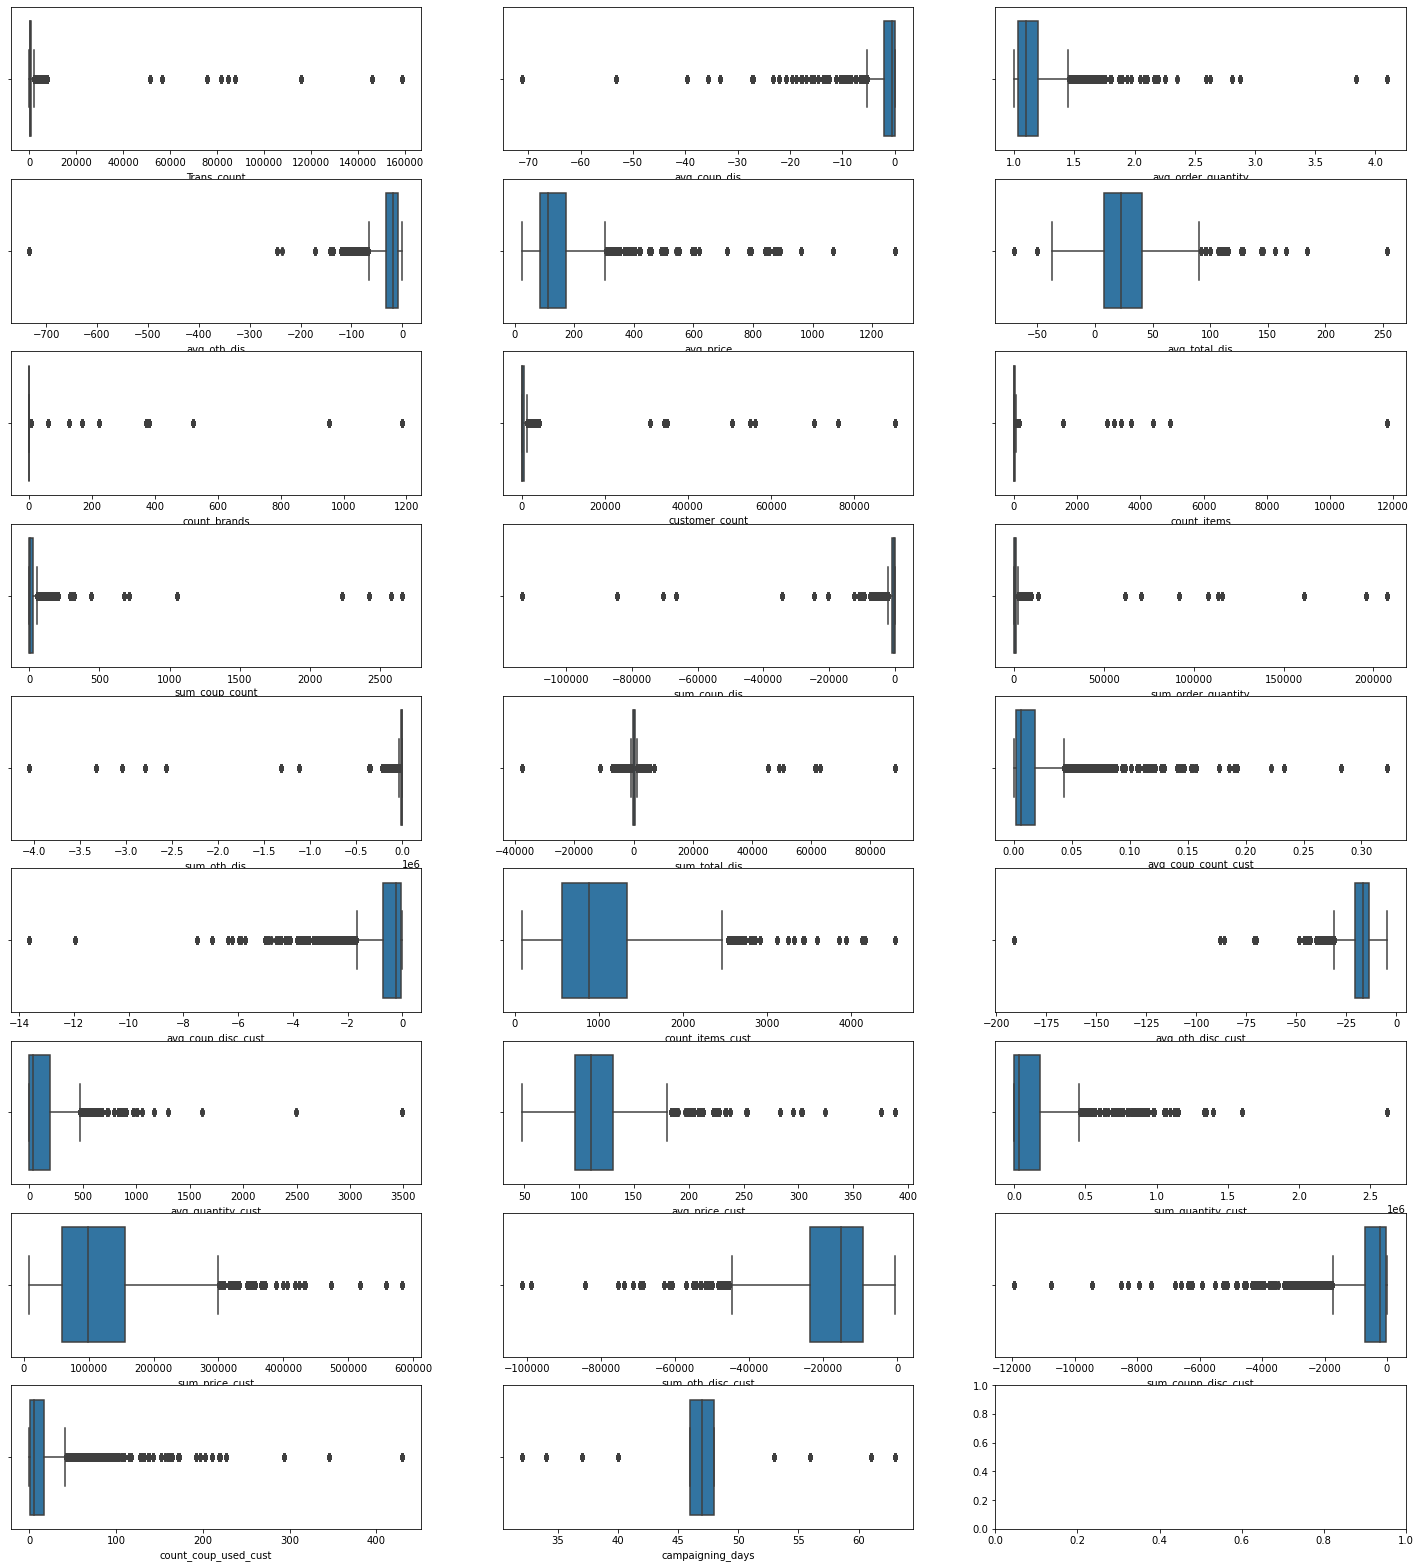

In [94]:
##### Numerical data Analysis

fig,ax=plt.subplots(9,3,figsize=(25,28))
for i,j in zip(df_num.columns,ax.flatten()):
    sns.boxplot(df_num[i],ax=j)
plt.show()


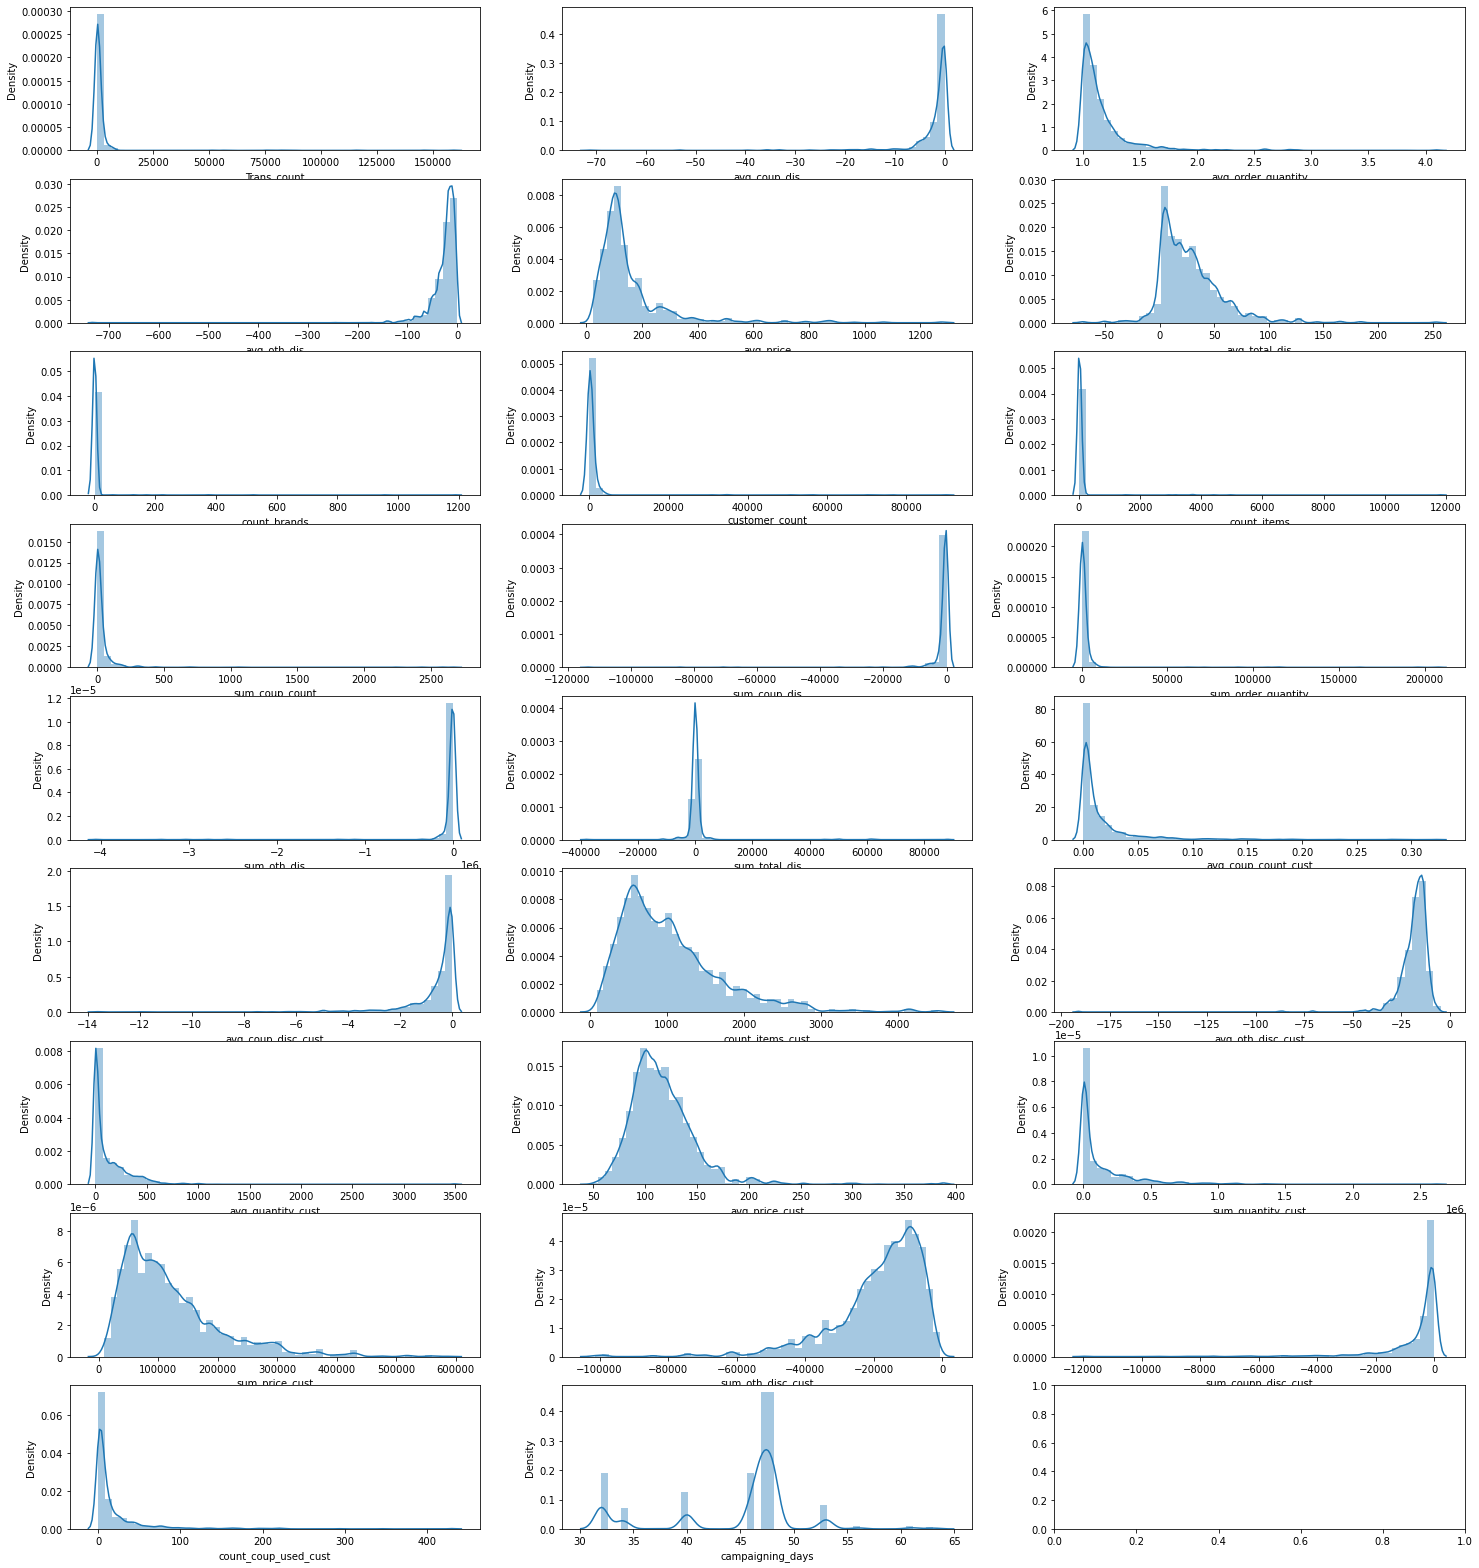

In [95]:
fig,ax=plt.subplots(9,3,figsize=(25,28))
for i,j in zip(df_num.columns,ax.flatten()):
    sns.distplot(df_num[i],ax=j)
plt.show()

In [96]:
df_num.skew()

Trans_count              9.957074
avg_coup_dis            -6.216903
avg_order_quantity       4.719839
avg_oth_dis             -9.526776
avg_price                3.556513
avg_total_dis            1.724299
count_brands            14.343605
customer_count           9.696949
count_items             13.980506
sum_coup_count          10.566542
sum_coup_dis           -11.461774
sum_order_quantity      10.058342
sum_oth_dis            -10.811267
sum_total_dis            8.215806
avg_coup_count_cust      4.149250
avg_coup_disc_cust      -4.753202
count_items_cust         1.513248
avg_oth_disc_cust       -8.961724
avg_quantity_cust        6.496068
avg_price_cust           2.302572
sum_quantity_cust        3.410050
sum_price_cust           1.558067
sum_oth_disc_cust       -1.833290
sum_coupp_disc_cust     -4.156255
count_coup_used_cust     4.878207
campaigning_days        -0.905796
dtype: float64

In [97]:
## here we have outliers in every numerical variable and the data is either positively skewed or negatively skewed

In [98]:
df_num.kurt()

Trans_count             106.753608
avg_coup_dis             50.962834
avg_order_quantity       34.242393
avg_oth_dis             219.138892
avg_price                16.960642
avg_total_dis             7.301682
count_brands            226.350312
customer_count           99.556951
count_items             235.683852
sum_coup_count          119.654890
sum_coup_dis            146.977615
sum_order_quantity      108.560094
sum_oth_dis             123.101983
sum_total_dis            84.006524
avg_coup_count_cust      24.178545
avg_coup_disc_cust       36.574263
count_items_cust          3.367093
avg_oth_disc_cust       153.572234
avg_quantity_cust        84.370961
avg_price_cust           13.178894
sum_quantity_cust        19.482313
sum_price_cust            3.165507
sum_oth_disc_cust         5.469823
sum_coupp_disc_cust      22.731111
count_coup_used_cust     33.322862
campaigning_days          0.504098
dtype: float64

<AxesSubplot:>

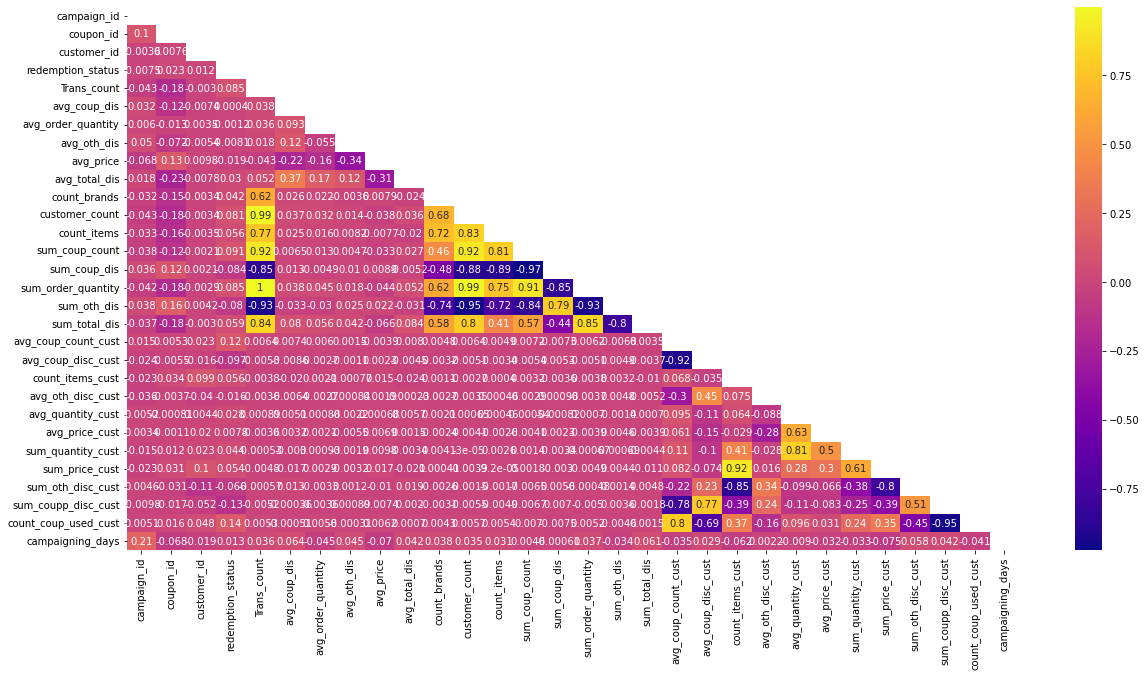

In [99]:
plt.figure(figsize=(20,10))
sns.heatmap(df_final.corr(),annot=True,mask=np.triu(df_final.corr()),cmap='plasma')

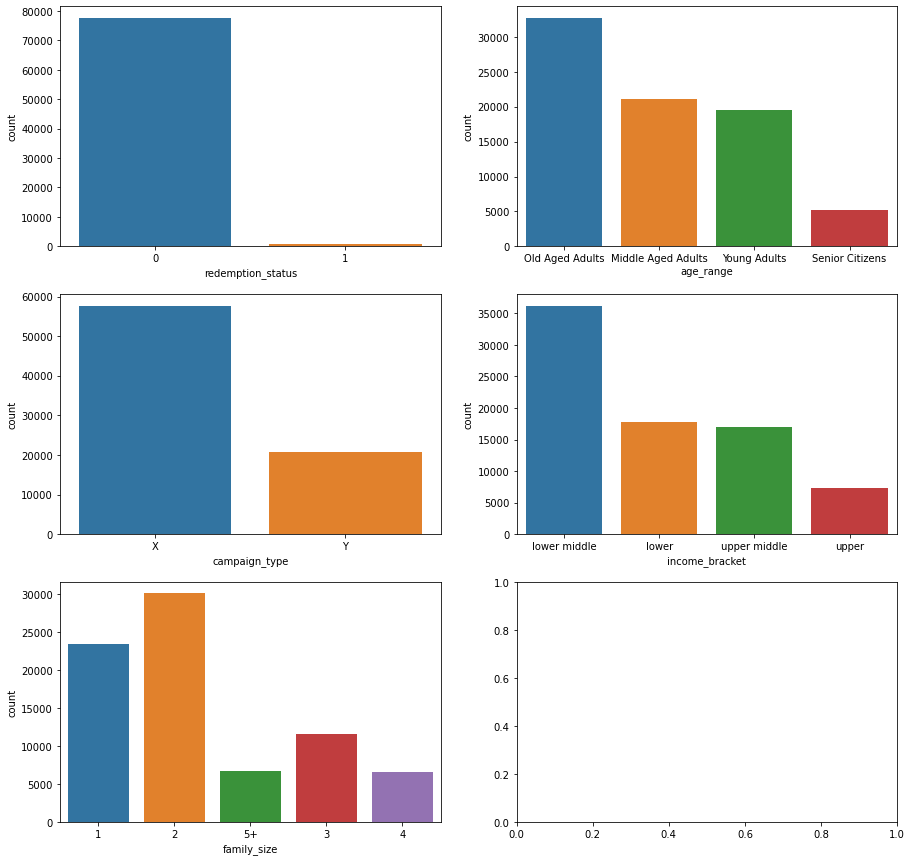

In [100]:

##### Categorical data Analysis

fig,ax=plt.subplots(3,2,figsize=(15,15))
for i,j in zip(df_cat.columns,ax.flatten()):
    sns.countplot(df_cat[i],ax=j)
plt.show()



### Bivarient Analysis

In [101]:
## here we will do bivarient analysis with respect to our target variable which is redemption_status

##### NUM vs CAT (target variable)

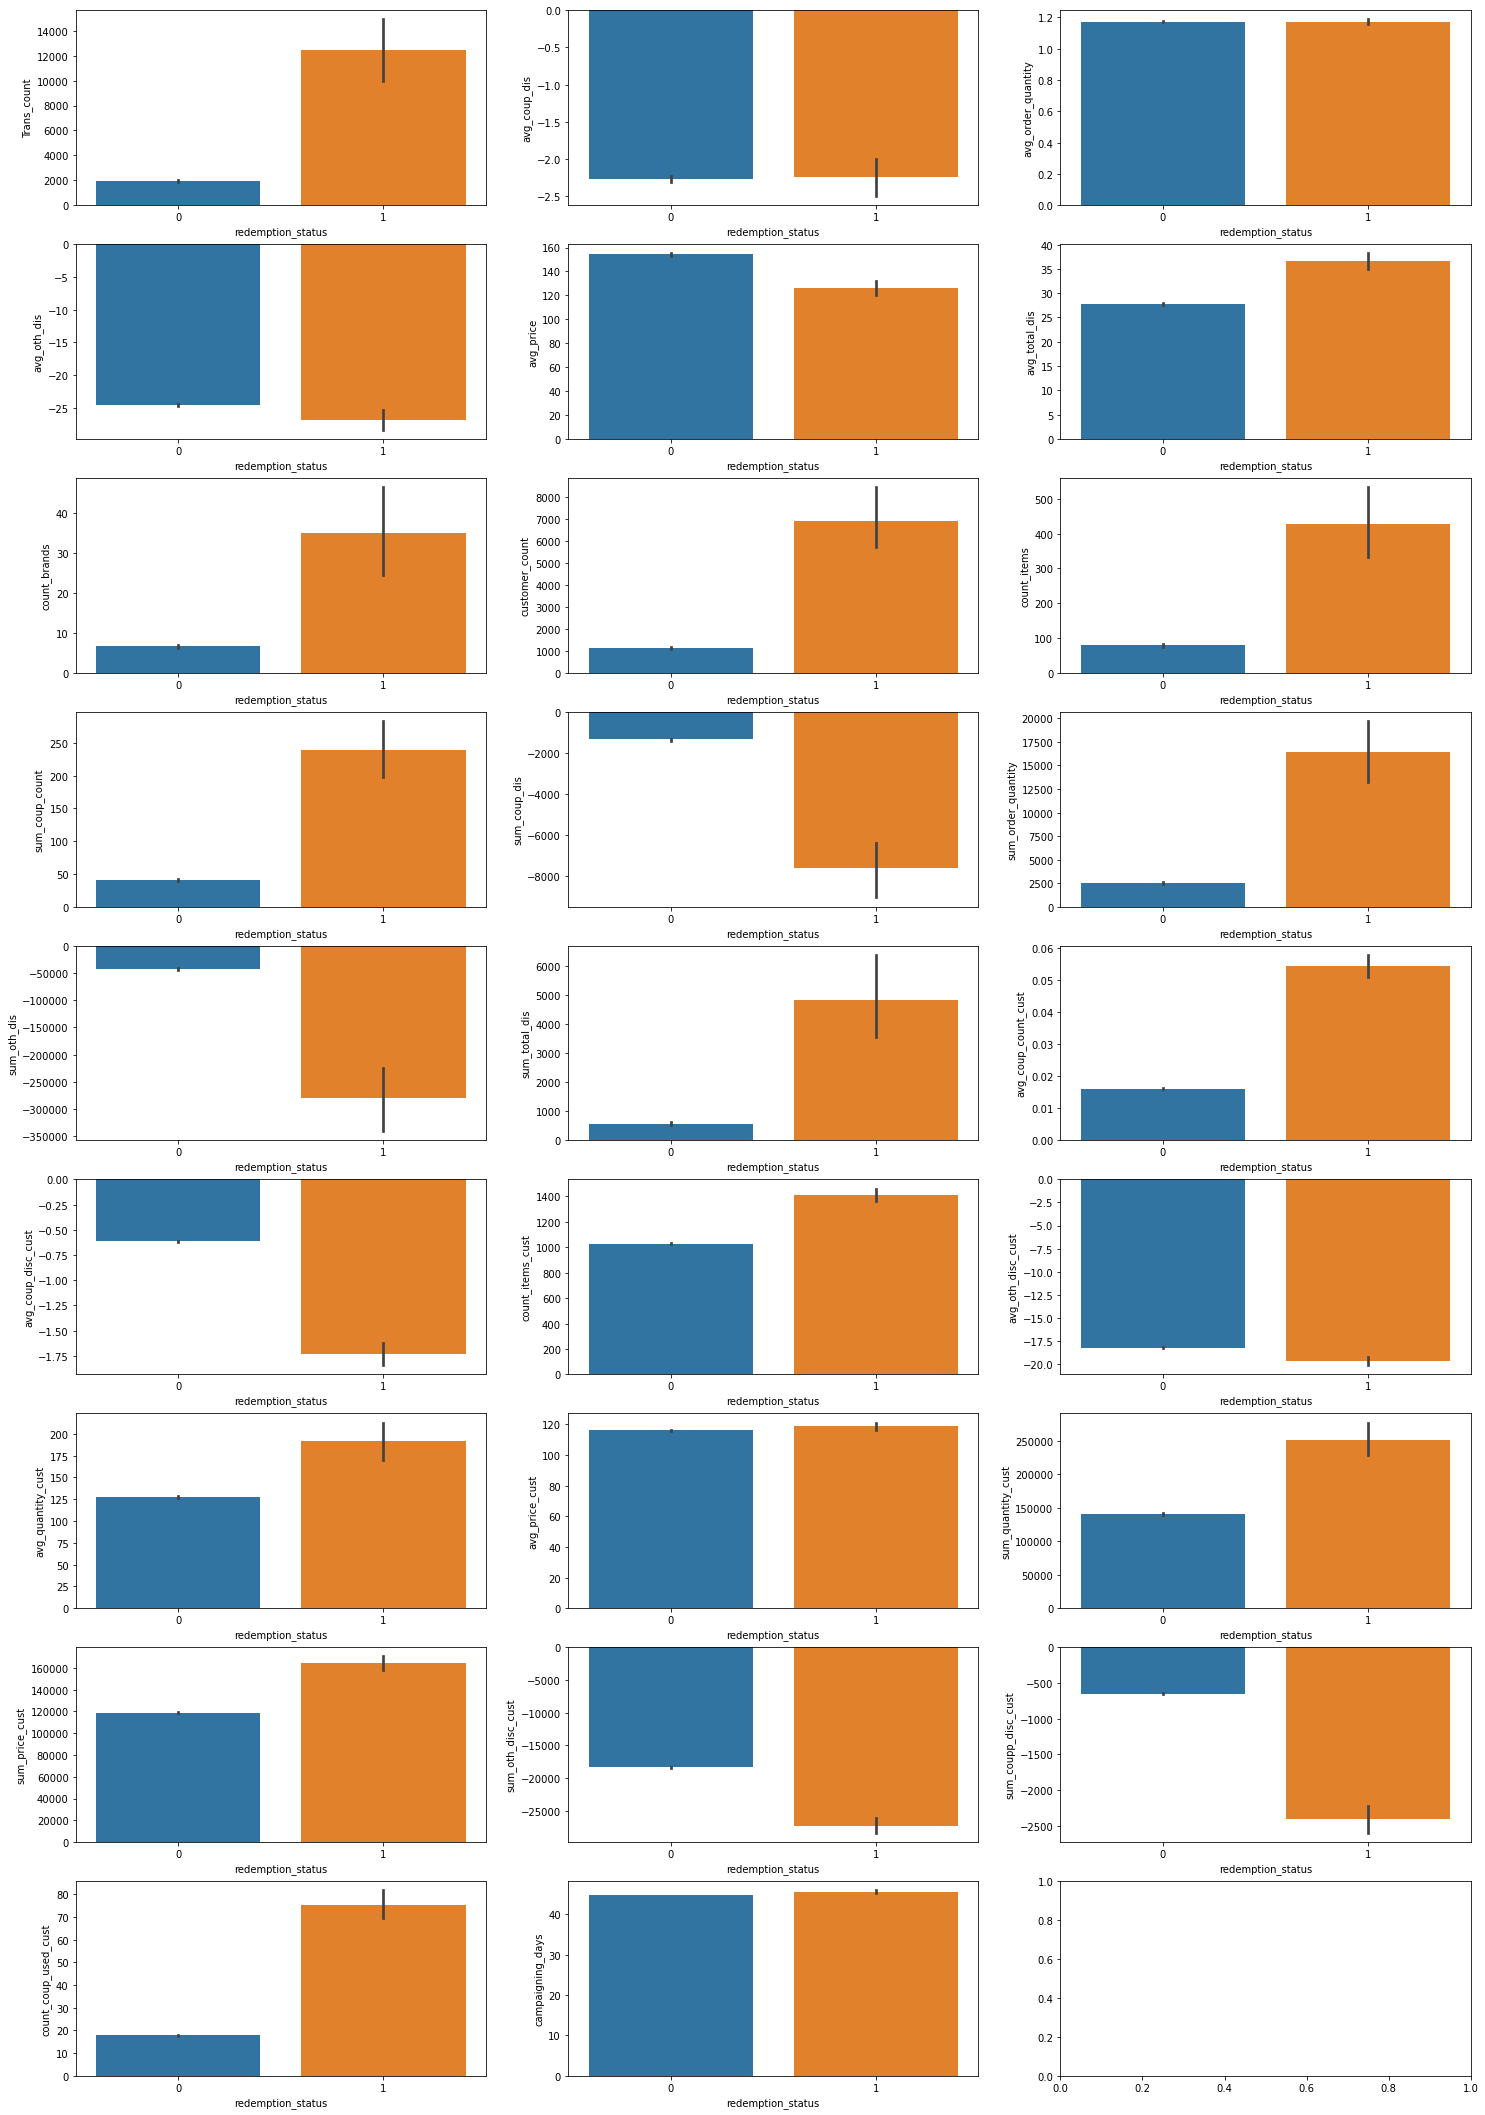

In [102]:
fig,ax=plt.subplots(9,3,figsize=(25,38))
for i,j in zip(df_num.columns,ax.flatten()):
    sns.barplot(x=df_final['redemption_status'],y=df_num[i],ax=j)
plt.show()


##### CAT vs CAT (target variable)

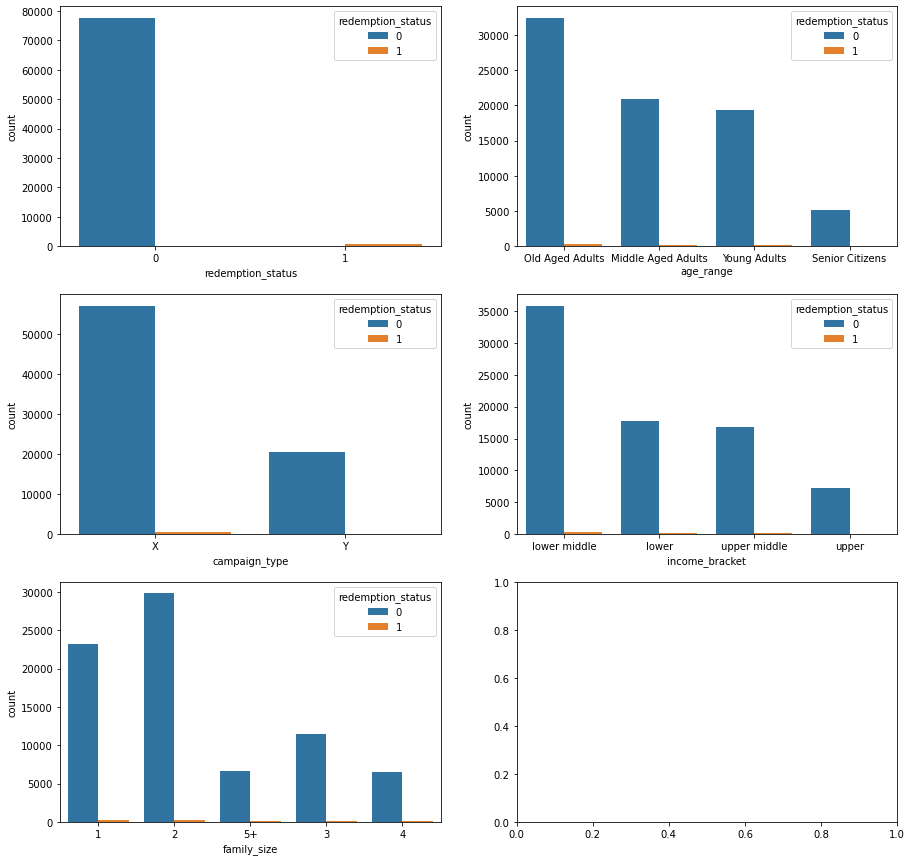

In [103]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
for i,j in zip(df_cat.columns,ax.flatten()):
    sns.countplot(x=df_cat[i],hue=df_final['redemption_status'],ax=j)
plt.show()

##### Imbalance data

In [104]:
## we will check for imbalance percentage persent in our target variable

df_final['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

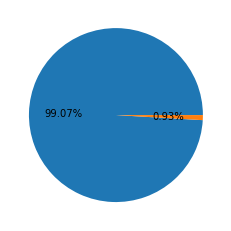

In [105]:
plt.pie(df_final["redemption_status"].value_counts(),autopct='%.2f%%')
plt.show()


## here we can see that their is clear imbalance in the target variable for the classes which are present

In [106]:
df_final["redemption_status"]=df_final["redemption_status"].astype("object")
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   campaign_id           78369 non-null  int64  
 1   coupon_id             78369 non-null  int64  
 2   customer_id           78369 non-null  int64  
 3   redemption_status     78369 non-null  object 
 4   Trans_count           78369 non-null  int64  
 5   avg_coup_dis          78369 non-null  float64
 6   avg_order_quantity    78369 non-null  float64
 7   avg_oth_dis           78369 non-null  float64
 8   avg_price             78369 non-null  float64
 9   avg_total_dis         78369 non-null  float64
 10  count_brands          78369 non-null  int64  
 11  customer_count        78369 non-null  int64  
 12  count_items           78369 non-null  int64  
 13  sum_coup_count        78369 non-null  int64  
 14  sum_coup_dis          78369 non-null  float64
 15  sum_order_quantity 

### Statistical significance of Variables

In [107]:
### Here we will do hypothesis testing for individual variables with our target variable to know if it is significant or not

In [108]:
# 1 .assuming data is normal and has equal variance

In [109]:
import scipy.stats as sts

In [110]:
# 2. hypothesis formation
#h0 : variable is independent
#h1: variable is dependent

In [111]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["Trans_count"])

p < 0.05

True

In [112]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_coup_dis"])

p < 0.05

True

In [113]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_order_quantity"])

p < 0.05

True

In [114]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_oth_dis"])

p < 0.05

True

In [115]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_price"])

p < 0.05

True

In [116]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_total_dis"])

p < 0.05

True

In [117]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["count_brands"])

p < 0.05

True

In [118]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["customer_count"])

p < 0.05

True

In [119]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["count_items"])

p < 0.05

True

In [120]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_coup_count"])

p < 0.05

True

In [121]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_coup_dis"])

p < 0.05

True

In [122]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_order_quantity"])

p < 0.05

True

In [123]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_oth_dis"])

p < 0.05

True

In [124]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_total_dis"])

p < 0.05

True

In [125]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_coup_count_cust"])

p < 0.05

True

In [126]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_coup_disc_cust"])

p < 0.05

True

In [127]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["count_items_cust"])

p < 0.05

True

In [128]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_oth_disc_cust"])

p < 0.05

True

In [129]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_quantity_cust"])

p < 0.05

True

In [130]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["avg_price_cust"])

p < 0.05

True

In [131]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_quantity_cust"])

p < 0.05

True

In [132]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_price_cust"])

p < 0.05

True

In [133]:

t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_oth_disc_cust"])

p < 0.05

True

In [134]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["sum_coupp_disc_cust"])

p < 0.05

True

In [135]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["count_coup_used_cust"])

p < 0.05

True

In [136]:
t,p=sts.f_oneway(df_final["redemption_status"],df_final["campaigning_days"])

p < 0.05

True

In [137]:
sts.chi2_contingency(pd.crosstab(df_final["redemption_status"],df_final["age_range"]))

(4.675203447746329,
 0.1971848873953901,
 3,
 array([[20859.1432837 , 32414.64303487,  5090.20556598, 19276.00811545],
        [  195.8567163 ,   304.35696513,    47.79443402,   180.99188455]]))

In [138]:
p=0.15125690202971068
p < 0.05

False

In [139]:
sts.chi2_contingency(pd.crosstab(df_final["redemption_status"],df_final["campaign_type"]))

(69.73207526234057,
 6.793239027041997e-17,
 1,
 array([[57147.41492172, 20492.58507828],
        [  536.58507828,   192.41492172]]))

In [140]:
p=6.793239027041997e-17
p < 0.05

True

In [141]:
sts.chi2_contingency(pd.crosstab(df_final["redemption_status"],df_final["income_bracket"]))



(11.288341044726963,
 0.010264640577920998,
 3,
 array([[17690.89155151, 35892.98319489,  7215.25245952, 16840.87279409],
        [  166.10844849,   337.01680511,    67.74754048,   158.12720591]]))

In [142]:
p= 0.0008482856914014823
p < 0.05

True

In [143]:
sts.chi2_contingency(pd.crosstab(df_final["redemption_status"],df_final["family_size"]))


(12.079246010112183,
 0.01677159853235815,
 4,
 array([[23170.4413735 , 29796.2286108 , 11416.80205183,  6552.47559622,
          6704.05236765],
        [  217.5586265 ,   279.7713892 ,   107.19794817,    61.52440378,
            62.94763235]]))

In [144]:
p= 0.031229262877450387
p < 0.05

True

In [145]:
## taking our significance level as 0.05 

In [146]:
# since pval < sig level, we reject h0 for all the variables except age_range.
# concluding that all the variables are significant variable except age_range with respect to our target variable(redemption_status)

#### Encoding and Splitting Data

In [147]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   campaign_id           78369 non-null  int64  
 1   coupon_id             78369 non-null  int64  
 2   customer_id           78369 non-null  int64  
 3   redemption_status     78369 non-null  object 
 4   Trans_count           78369 non-null  int64  
 5   avg_coup_dis          78369 non-null  float64
 6   avg_order_quantity    78369 non-null  float64
 7   avg_oth_dis           78369 non-null  float64
 8   avg_price             78369 non-null  float64
 9   avg_total_dis         78369 non-null  float64
 10  count_brands          78369 non-null  int64  
 11  customer_count        78369 non-null  int64  
 12  count_items           78369 non-null  int64  
 13  sum_coup_count        78369 non-null  int64  
 14  sum_coup_dis          78369 non-null  float64
 15  sum_order_quantity 

In [148]:
df_cat.head(1)

,redemption_status,age_range,campaign_type,income_bracket,family_size
0,0,Old Aged Adults,X,lower middle,1


In [149]:
df_cat['age_range'].unique()

array(['Old Aged Adults', 'Middle Aged Adults', 'Young Adults',
       'Senior Citizens'], dtype=object)

In [150]:
df_cat['age_range']=df_cat['age_range'].map({'Old Aged Adults':0, 'Middle Aged Adults':1, 'Young Adults':2,
       'Senior Citizens':3})

In [151]:
df_cat['campaign_type'].unique()

array(['X', 'Y'], dtype=object)

In [152]:
df_cat['campaign_type']=df_cat['campaign_type'].map({'X':0, 'Y':1})

In [153]:
df_cat['income_bracket'].unique()

array(['lower middle', 'lower', 'upper middle', 'upper'], dtype=object)

In [154]:
df_cat['income_bracket']=df_cat['income_bracket'].map({'lower middle':0, 'lower':1, 'upper middle':2, 'upper':3})

In [155]:
df_cat['family_size'].unique()

array(['1', '2', '5+', '3', '4'], dtype=object)

In [156]:
df_cat['family_size']=df_cat['family_size'].map({'1':0, '2':1, '3':2, '5+':3, '4':4})

In [157]:
df_cat.head()

,redemption_status,age_range,campaign_type,income_bracket,family_size
0,0,0,0,0,0
1,0,1,0,1,1
2,0,0,1,2,1
3,0,2,0,0,1
4,0,0,0,1,1


In [158]:
df_final.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'Trans_count', 'avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands', 'customer_count',
       'count_items', 'sum_coup_count', 'sum_coup_dis', 'sum_order_quantity',
       'sum_oth_dis', 'sum_total_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust', 'age_range', 'family_size', 'income_bracket',
       'campaign_type', 'campaigning_days'],
      dtype='object')

In [159]:
df_final['customer_id'].value_counts()

1463    199
590     193
189     175
1192    173
464     171
       ... 
180       8
219       8
1476      8
1354      8
618       8
Name: customer_id, Length: 1428, dtype: int64

In [160]:
pd.options.display.max_columns=50

In [161]:
df_num.columns

Index(['Trans_count', 'avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands', 'customer_count',
       'count_items', 'sum_coup_count', 'sum_coup_dis', 'sum_order_quantity',
       'sum_oth_dis', 'sum_total_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust', 'campaigning_days'],
      dtype='object')

In [162]:
df_num.head()

,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days
0,3713,-1.241694,1.169768,-51.732305,84.478583,28.462306,2,2403,125,191,-5349.93,4661.0,-225584.38,-1636.93,0.003226,-0.287258,310,-33.168935,340.487097,184.260484,105551.0,57120.75,-10282.37,-89.05,1.0,47
1,75,0.000000,1.050926,-10.661343,63.833519,25.000000,1,61,3,0,0.00,86.0,-684.27,75.00,0.031169,-3.215039,385,-27.699169,31.540260,234.247013,12143.0,90185.10,-10664.18,-1237.79,12.0,47
2,142,-2.987321,1.353802,-142.498493,332.128380,-0.867918,1,118,67,15,-605.54,202.0,-23566.35,-463.54,0.087629,-2.212082,970,-17.795660,1.392784,121.094495,1351.0,117461.66,-17261.79,-2145.72,85.0,32
3,39,-4.452500,1.110390,-5.010601,94.261640,5.297500,1,14,4,1,-17.81,47.0,-309.91,21.19,0.008439,-0.751477,237,-16.655570,1.291139,98.276034,306.0,23291.42,-3947.37,-178.10,2.0,47
4,1420,-0.198055,1.071044,-33.629121,181.621631,44.176945,1,874,32,23,-569.92,1610.0,-54950.74,850.08,0.017794,-0.471548,562,-20.524733,247.443060,120.636103,139063.0,67797.49,-11534.90,-265.01,10.0,48


In [163]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
scaled_data=pd.DataFrame(sc.fit_transform(df_num),columns=[['Trans_count', 'avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands', 'customer_count',
       'count_items', 'sum_coup_count', 'sum_coup_dis', 'sum_order_quantity',
       'sum_oth_dis', 'sum_total_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust', 'campaigning_days']])
df_num[['Trans_count', 'avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands', 'customer_count',
       'count_items', 'sum_coup_count', 'sum_coup_dis', 'sum_order_quantity',
       'sum_oth_dis', 'sum_total_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust', 'campaigning_days']]=scaled_data
df_num.head()


,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days
0,0.140786,0.176138,-0.012769,-1.009014,-0.500611,0.023466,-0.075422,0.179881,0.071213,0.711921,-0.550822,0.128690,-0.632939,-0.326890,-0.440592,0.305052,-1.097975,-1.718802,0.982589,2.161641,-0.147977,-0.757737,0.625393,0.455543,-0.449826,0.362643
1,-0.163867,0.389675,-0.461816,0.519925,-0.649456,-0.098358,-0.090874,-0.162888,-0.130454,-0.203806,0.197203,-0.160847,0.154508,-0.079091,0.485985,-2.345483,-0.984004,-1.087632,-0.446425,3.744679,-0.534847,-0.354027,0.596124,-0.444733,-0.165313,0.362643
2,-0.158256,-0.124061,0.682610,-4.387947,1.284872,-1.008540,-0.090874,-0.154546,-0.024662,-0.131890,0.112536,-0.153506,0.074390,-0.157044,2.358174,-1.437502,-0.095029,0.055159,-0.585870,0.161218,-0.579545,-0.020984,0.090370,-1.156285,1.722817,-2.078113
3,-0.166882,-0.376031,-0.237131,0.730284,-0.430078,-0.791605,-0.090874,-0.169767,-0.128801,-0.199011,0.194713,-0.163316,0.155819,-0.086880,-0.267731,-0.115208,-1.208907,0.186717,-0.586340,-0.561426,-0.583873,-1.170788,1.111016,0.385754,-0.423961,0.362643
4,-0.051234,0.355615,-0.385799,-0.335091,0.199762,0.576397,-0.090874,-0.043900,-0.082517,-0.093535,0.117517,-0.064398,-0.035496,0.033101,0.042469,0.138213,-0.715032,-0.259756,0.552219,0.146701,-0.009180,-0.627376,0.529377,0.317642,-0.217043,0.525360


In [164]:
df_encoded=pd.concat([df_final['coupon_id'],df_num,df_cat],axis=1)


In [165]:
df_encoded.head()

,coupon_id,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days,redemption_status,age_range,campaign_type,income_bracket,family_size
0,27,0.140786,0.176138,-0.012769,-1.009014,-0.500611,0.023466,-0.075422,0.179881,0.071213,0.711921,-0.550822,0.128690,-0.632939,-0.326890,-0.440592,0.305052,-1.097975,-1.718802,0.982589,2.161641,-0.147977,-0.757737,0.625393,0.455543,-0.449826,0.362643,0,0,0,0,0
1,116,-0.163867,0.389675,-0.461816,0.519925,-0.649456,-0.098358,-0.090874,-0.162888,-0.130454,-0.203806,0.197203,-0.160847,0.154508,-0.079091,0.485985,-2.345483,-0.984004,-1.087632,-0.446425,3.744679,-0.534847,-0.354027,0.596124,-0.444733,-0.165313,0.362643,0,1,0,1,1
2,635,-0.158256,-0.124061,0.682610,-4.387947,1.284872,-1.008540,-0.090874,-0.154546,-0.024662,-0.131890,0.112536,-0.153506,0.074390,-0.157044,2.358174,-1.437502,-0.095029,0.055159,-0.585870,0.161218,-0.579545,-0.020984,0.090370,-1.156285,1.722817,-2.078113,0,0,1,2,1
3,644,-0.166882,-0.376031,-0.237131,0.730284,-0.430078,-0.791605,-0.090874,-0.169767,-0.128801,-0.199011,0.194713,-0.163316,0.155819,-0.086880,-0.267731,-0.115208,-1.208907,0.186717,-0.586340,-0.561426,-0.583873,-1.170788,1.111016,0.385754,-0.423961,0.362643,0,2,0,0,1
4,1017,-0.051234,0.355615,-0.385799,-0.335091,0.199762,0.576397,-0.090874,-0.043900,-0.082517,-0.093535,0.117517,-0.064398,-0.035496,0.033101,0.042469,0.138213,-0.715032,-0.259756,0.552219,0.146701,-0.009180,-0.627376,0.529377,0.317642,-0.217043,0.525360,0,0,0,1,1


In [166]:
df_encoded.shape

(78369, 32)

In [167]:
df_enc=df_encoded.drop_duplicates(keep='first')

In [168]:
df_enc.shape

(78338, 32)

In [169]:
### Spliting of data

In [170]:
X=df_enc.drop(['redemption_status'],axis=1)
y=df_enc['redemption_status']

In [171]:
X.head()

,coupon_id,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days,age_range,campaign_type,income_bracket,family_size
0,27,0.140786,0.176138,-0.012769,-1.009014,-0.500611,0.023466,-0.075422,0.179881,0.071213,0.711921,-0.550822,0.128690,-0.632939,-0.326890,-0.440592,0.305052,-1.097975,-1.718802,0.982589,2.161641,-0.147977,-0.757737,0.625393,0.455543,-0.449826,0.362643,0,0,0,0
1,116,-0.163867,0.389675,-0.461816,0.519925,-0.649456,-0.098358,-0.090874,-0.162888,-0.130454,-0.203806,0.197203,-0.160847,0.154508,-0.079091,0.485985,-2.345483,-0.984004,-1.087632,-0.446425,3.744679,-0.534847,-0.354027,0.596124,-0.444733,-0.165313,0.362643,1,0,1,1
2,635,-0.158256,-0.124061,0.682610,-4.387947,1.284872,-1.008540,-0.090874,-0.154546,-0.024662,-0.131890,0.112536,-0.153506,0.074390,-0.157044,2.358174,-1.437502,-0.095029,0.055159,-0.585870,0.161218,-0.579545,-0.020984,0.090370,-1.156285,1.722817,-2.078113,0,1,2,1
3,644,-0.166882,-0.376031,-0.237131,0.730284,-0.430078,-0.791605,-0.090874,-0.169767,-0.128801,-0.199011,0.194713,-0.163316,0.155819,-0.086880,-0.267731,-0.115208,-1.208907,0.186717,-0.586340,-0.561426,-0.583873,-1.170788,1.111016,0.385754,-0.423961,0.362643,2,0,0,1
4,1017,-0.051234,0.355615,-0.385799,-0.335091,0.199762,0.576397,-0.090874,-0.043900,-0.082517,-0.093535,0.117517,-0.064398,-0.035496,0.033101,0.042469,0.138213,-0.715032,-0.259756,0.552219,0.146701,-0.009180,-0.627376,0.529377,0.317642,-0.217043,0.525360,0,0,1,1


In [172]:
X['coupon_id'].value_counts()

705     548
470     447
691     405
468     366
1043    357
       ... 
404      12
398      12
389      12
823      12
1091     12
Name: coupon_id, Length: 866, dtype: int64

In [173]:
X.shape

(78338, 31)

In [174]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: redemption_status, dtype: int64

In [175]:
from sklearn.model_selection import train_test_split

In [176]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=10)

In [177]:
xtrain.shape

(54836, 31)

In [178]:
ytrain.shape

(54836,)

In [179]:
xtest.shape

(23502, 31)

In [180]:
ytest.shape

(23502,)

In [181]:
## Now we will build our base model with the splitted data

### Base Model

In [182]:
from sklearn.linear_model import LogisticRegression

In [183]:
lr=LogisticRegression()
base_model=lr.fit(xtrain,ytrain)

In [184]:
y_pred_test=base_model.predict(xtest)


In [185]:
### Importing metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,cohen_kappa_score

In [186]:
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.008888888888888889
0.008476375159627292


In [187]:
#### checking for distribution of our target variable classes in X and y splits

In [188]:
ytrain.value_counts()/len(ytrain)*100

0    99.08819
1     0.91181
Name: redemption_status, dtype: float64

In [189]:
ytest.value_counts()/len(ytest)*100

0    99.063909
1     0.936091
Name: redemption_status, dtype: float64

In [190]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,stratify=y)

In [191]:
ytrain.value_counts()/len(ytrain)*100

0    99.080896
1     0.919104
Name: redemption_status, dtype: float64

In [192]:
ytest.value_counts()/len(ytest)*100

0    99.080929
1     0.919071
Name: redemption_status, dtype: float64

In [193]:
lr=LogisticRegression()
base_model=lr.fit(xtrain,ytrain)
y_pred_test=base_model.predict(xtest)

In [194]:
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.0
-0.0005773281847267775


In [195]:
### we will perform SMOTE here

In [196]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.2)

In [197]:
xtrain_resampled,ytrain_resampled = smote.fit_resample(xtrain,ytrain)

In [198]:
xtrain_resampled.shape

(65198, 31)

In [199]:
xtrain.shape

(54836, 31)

In [200]:
ytrain_resampled.value_counts()/len(ytrain_resampled)*100

0    83.333845
1    16.666155
Name: redemption_status, dtype: float64

In [201]:
ytest.value_counts()/len(ytest)*100

0    99.080929
1     0.919071
Name: redemption_status, dtype: float64

In [202]:
lr=LogisticRegression()
smote_lr=lr.fit(xtrain_resampled,ytrain_resampled)
y_pred_test=smote_lr.predict(xtest)

In [203]:
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.12167300380228135
0.10796953384912089


### Decision tree

In [204]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt_model=dt.fit(xtrain,ytrain)
y_pred_test=dt_model.predict(xtest)

In [205]:
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.14901960784313725
0.13990575268833516


#### Grid Search cv

In [206]:
from sklearn.model_selection import GridSearchCV

In [207]:
  tuned_paramaters = [{'criterion': ['entropy','gini'], 
                     'max_depth': [3,4,5],  
                     'max_features': ["sqrt", "log2"], 
                       'min_samples_split': [1,2,3],
                     'min_samples_leaf': [2,3,4,5],
                     'max_leaf_nodes': [6,7,8,9],
                      'random_state':[10]}]

In [208]:
dt = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = dt,
                         param_grid = tuned_paramaters, 
                         cv = 5)

In [209]:
tree_grid_model = tree_grid.fit(xtrain_resampled,ytrain_resampled)
print('Best parameters for decision tree classifer: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifer:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 10} 



In [210]:
dt_grid_model = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 5,
                                  max_features = 'log2',
                                  max_leaf_nodes = 7,
                                       min_samples_leaf=2,
                                  min_samples_split = 2,
                                  random_state = 10)

In [211]:
dt_grid_model=dt_grid_model.fit(xtrain_resampled,ytrain_resampled)

In [212]:
ypred_dt_test = dt_grid_model.predict(xtest)
print('Testing Data')
print('--------------')
print(f1_score(ytest,ypred_dt_test))
print(cohen_kappa_score(ytest,ypred_dt_test))

Testing Data
--------------
0.13295880149812733
0.11839233335180588


#### KNN

In [213]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain_resampled,ytrain_resampled)


KNeighborsClassifier(n_neighbors=3)

In [214]:
ypred_knn = knn.predict(xtest)
print(f1_score(ytest, ypred_knn))
print(cohen_kappa_score(ytest, ypred_knn))

0.14964610717896865
0.13725110698415532


### Naive Bayes

In [215]:
 from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [216]:
gnb=GaussianNB()
gnb.fit(xtrain_resampled,ytrain_resampled)

GaussianNB()

In [217]:
ypred_gnb = gnb.predict(xtest)
print(f1_score(ytest, ypred_gnb))
print(cohen_kappa_score(ytest, ypred_gnb))

0.1197301854974705
0.10629448205113856


In [218]:
bnb=BernoulliNB()
bnb.fit(xtrain_resampled,ytrain_resampled)

BernoulliNB()

In [219]:
ypred_bnb = bnb.predict(xtest)
print(f1_score(ytest, ypred_bnb))
print(cohen_kappa_score(ytest, ypred_bnb))

0.08543140028288543
0.06937036119523254


### Random Forest

In [220]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()
rf_model=rf.fit(xtrain_resampled,ytrain_resampled)
y_pred_test=rf_model.predict(xtest)

In [221]:
print('Testing Data')
print(accuracy_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.9859160922474683
0.19913930115008982


In [222]:
params =             [{'criterion': ['entropy', 'gini'],
                     'max_depth': [8,9],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2,3],
                     'min_samples_leaf': [5,6],
                     'max_leaf_nodes': [9,10]}]

In [223]:
rf =RandomForestClassifier(random_state=10)

rf_cv = GridSearchCV(rf,params,cv=5,scoring='accuracy')

rf_cv.fit(xtrain_resampled,ytrain_resampled)

rf_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [224]:
rf_model = RandomForestClassifier(criterion ='entropy' , 
                                  max_depth = 8 ,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 10 ,
                                  min_samples_leaf = 5 ,
                                  min_samples_split = 2,
                                  random_state = 10)


rf_model.fit(xtrain_resampled,ytrain_resampled)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=10, min_samples_leaf=5, random_state=10)

In [225]:
ypred_rf_tp = rf_model.predict(xtest)
print(f1_score(ytest,ypred_rf_tp))
print(cohen_kappa_score(ytest,ypred_rf_tp))

0.19272727272727275
0.18062346468311807


### AdaBoost

In [226]:
from sklearn.ensemble import AdaBoostClassifier
adb=AdaBoostClassifier()
adb=adb.fit(xtrain_resampled,ytrain_resampled)

In [227]:
ypred_adb = adb.predict(xtest)
print(f1_score(ytest,ypred_adb))
print(cohen_kappa_score(ytest,ypred_adb))

0.17025440313111548
0.15804906388667384


### Gradient Boosting

In [228]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc=gbc.fit(xtrain_resampled,ytrain_resampled)

In [229]:
ypred_gbc = gbc.predict(xtest)
print(f1_score(ytest,ypred_gbc))
print(cohen_kappa_score(ytest,ypred_gbc))

0.21260815822002474
0.20185422549155407


### XGBoost

In [230]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=10)

In [231]:
xgb=xgb.fit(xtrain_resampled,ytrain_resampled)

In [232]:
ypred_xgb = xgb.predict(xtest)
print(f1_score(ytest,ypred_xgb))
print(cohen_kappa_score(ytest,ypred_xgb))

0.2096774193548387
0.20353802358682394


## Improving the models


### VIF model Checking for multi collinearity

In [233]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif_data=pd.DataFrame()

vif_data

vif_data['Variables']=df_num.columns

vif_data

,Variables
0,Trans_count
1,avg_coup_dis
2,avg_order_quantity
3,avg_oth_dis
4,avg_price
5,avg_total_dis
6,count_brands
7,customer_count
8,count_items
9,sum_coup_count


In [234]:
vif_data['VIF Values']=[variance_inflation_factor(df_num.values,i)
                       for i in range(len(df_num.columns))]
vif_data['VIF Values'].sort_values()
vif_data.sort_values('VIF Values',ascending=False)

,Variables,VIF Values
0,Trans_count,inf
10,sum_coup_dis,inf
13,sum_total_dis,inf
11,sum_order_quantity,1148.389224
7,customer_count,287.694081
9,sum_coup_count,107.209042
8,count_items,63.463093
12,sum_oth_dis,48.780411
23,sum_coupp_disc_cust,42.356775
24,count_coup_used_cust,40.466808


In [235]:
df_num.columns

Index(['Trans_count', 'avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands', 'customer_count',
       'count_items', 'sum_coup_count', 'sum_coup_dis', 'sum_order_quantity',
       'sum_oth_dis', 'sum_total_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust', 'campaigning_days'],
      dtype='object')

In [236]:
vif_num_data = df_num[['avg_coup_dis', 'avg_order_quantity', 'avg_oth_dis',
       'avg_price', 'avg_total_dis', 'count_brands',
       'count_items',
       'sum_oth_dis', 'avg_coup_count_cust',
       'avg_coup_disc_cust', 'count_items_cust', 'avg_oth_disc_cust',
       'avg_quantity_cust', 'avg_price_cust', 'sum_quantity_cust',
       'sum_price_cust', 'sum_oth_disc_cust', 'sum_coupp_disc_cust',
       'count_coup_used_cust', 'campaigning_days']]

In [237]:
vif_num_data.head()

,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,count_items,sum_oth_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days
0,0.176138,-0.012769,-1.009014,-0.500611,0.023466,-0.075422,0.071213,-0.632939,-0.440592,0.305052,-1.097975,-1.718802,0.982589,2.161641,-0.147977,-0.757737,0.625393,0.455543,-0.449826,0.362643
1,0.389675,-0.461816,0.519925,-0.649456,-0.098358,-0.090874,-0.130454,0.154508,0.485985,-2.345483,-0.984004,-1.087632,-0.446425,3.744679,-0.534847,-0.354027,0.596124,-0.444733,-0.165313,0.362643
2,-0.124061,0.682610,-4.387947,1.284872,-1.008540,-0.090874,-0.024662,0.074390,2.358174,-1.437502,-0.095029,0.055159,-0.585870,0.161218,-0.579545,-0.020984,0.090370,-1.156285,1.722817,-2.078113
3,-0.376031,-0.237131,0.730284,-0.430078,-0.791605,-0.090874,-0.128801,0.155819,-0.267731,-0.115208,-1.208907,0.186717,-0.586340,-0.561426,-0.583873,-1.170788,1.111016,0.385754,-0.423961,0.362643
4,0.355615,-0.385799,-0.335091,0.199762,0.576397,-0.090874,-0.082517,-0.035496,0.042469,0.138213,-0.715032,-0.259756,0.552219,0.146701,-0.009180,-0.627376,0.529377,0.317642,-0.217043,0.525360


In [238]:
df_final_vif=pd.concat([vif_num_data,df_cat,df_final['coupon_id']],axis=1)
df_final_vif.head()

,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,count_items,sum_oth_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days,redemption_status,age_range,campaign_type,income_bracket,family_size,coupon_id
0,0.176138,-0.012769,-1.009014,-0.500611,0.023466,-0.075422,0.071213,-0.632939,-0.440592,0.305052,-1.097975,-1.718802,0.982589,2.161641,-0.147977,-0.757737,0.625393,0.455543,-0.449826,0.362643,0,0,0,0,0,27
1,0.389675,-0.461816,0.519925,-0.649456,-0.098358,-0.090874,-0.130454,0.154508,0.485985,-2.345483,-0.984004,-1.087632,-0.446425,3.744679,-0.534847,-0.354027,0.596124,-0.444733,-0.165313,0.362643,0,1,0,1,1,116
2,-0.124061,0.682610,-4.387947,1.284872,-1.008540,-0.090874,-0.024662,0.074390,2.358174,-1.437502,-0.095029,0.055159,-0.585870,0.161218,-0.579545,-0.020984,0.090370,-1.156285,1.722817,-2.078113,0,0,1,2,1,635
3,-0.376031,-0.237131,0.730284,-0.430078,-0.791605,-0.090874,-0.128801,0.155819,-0.267731,-0.115208,-1.208907,0.186717,-0.586340,-0.561426,-0.583873,-1.170788,1.111016,0.385754,-0.423961,0.362643,0,2,0,0,1,644
4,0.355615,-0.385799,-0.335091,0.199762,0.576397,-0.090874,-0.082517,-0.035496,0.042469,0.138213,-0.715032,-0.259756,0.552219,0.146701,-0.009180,-0.627376,0.529377,0.317642,-0.217043,0.525360,0,0,0,1,1,1017


In [239]:
df_final_vif.shape

(78369, 26)

In [240]:
from sklearn.model_selection import train_test_split
X=df_final_vif.drop('redemption_status',axis=1)
y=df_final_vif['redemption_status']

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.30,stratify=y,random_state=100)

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(54858, 25)
(54858,)
(23511, 25)
(23511,)


In [241]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.2)


In [242]:
xtrain_resampled,ytrain_resampled = smote.fit_resample(xtrain,ytrain)

In [243]:
lr=LogisticRegression()
smote_lr=lr.fit(xtrain_resampled,ytrain_resampled)
y_pred_test=smote_lr.predict(xtest)

In [244]:
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.12436974789915967
0.11085373852493785


### Decision tree

In [245]:
  tuned_paramaters = [{'criterion': ['entropy','gini'], 
                     'max_depth': [5,6,7],  
                     'max_features': ["sqrt", "log2"], 
                       'min_samples_split': [1,2],
                     'min_samples_leaf': [2,3],
                     'max_leaf_nodes': [9,10,11],
                      'random_state':[10]}]

dt = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = dt,
                         param_grid = tuned_paramaters, 
                         cv = 5)

In [246]:
tree_grid_model = tree_grid.fit(xtrain_resampled,ytrain_resampled)
print('Best parameters for decision tree classifer: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifer:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 10} 



In [247]:

dt_grid_model = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 7,
                                  max_features = 'sqrt',
                                  max_leaf_nodes =11,
                                       min_samples_leaf=2,
                                  min_samples_split = 2,
                                  random_state = 10)

In [248]:
dt_grid_model=dt_grid_model.fit(xtrain_resampled,ytrain_resampled)

In [249]:
ypred_dt_test = dt_grid_model.predict(xtest)
print('Testing Data')
print('--------------')
print(f1_score(ytest,ypred_dt_test))
print(cohen_kappa_score(ytest, ypred_dt_test))

Testing Data
--------------
0.19858156028368792
0.18736143738070776


### KNN

In [250]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(xtrain_resampled,ytrain_resampled)

KNeighborsClassifier()

In [251]:
ypred_knn = knn.predict(xtest)
print(f1_score(ytest,ypred_knn))
print(cohen_kappa_score(ytest, ypred_knn))

0.15766164747564212
0.14482038270760222


### Naive Bayes

In [252]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb=GaussianNB()
gnb.fit(xtrain_resampled,ytrain_resampled)

GaussianNB()

In [253]:
ypred_gnb = gnb.predict(xtest)
print(f1_score(ytest,ypred_gnb))
print(cohen_kappa_score(ytest, ypred_gnb))

0.1065482796892342
0.09168322636359416


In [254]:
bnb=BernoulliNB()
bnb.fit(xtrain_resampled,ytrain_resampled)

BernoulliNB()

In [255]:
ypred_bnb = bnb.predict(xtest)
print(f1_score(ytest,ypred_bnb))
print(cohen_kappa_score(ytest, ypred_bnb))

0.07062528115159694
0.053867451095886754


### Random Forest

In [256]:
params =             [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [50],
                     'max_depth': [10,11],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2,4],
                     'min_samples_leaf': [5,7],
                     'max_leaf_nodes': [8,9]}]

rf =RandomForestClassifier(random_state=10)

rf_cv = GridSearchCV(rf,params,cv=5,scoring='accuracy')

rf_cv.fit(xtrain_resampled,ytrain_resampled)

rf_cv.best_params_



{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [257]:
rf_model = RandomForestClassifier(criterion ='entropy' , 
                                  n_estimators =50 ,
                                  max_depth = 10 ,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 9 ,
                                  min_samples_leaf = 5 ,
                                  min_samples_split = 2,
                                  random_state = 10)


rf_model.fit(xtrain_resampled,ytrain_resampled)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=9, min_samples_leaf=5, n_estimators=50,
                       random_state=10)

In [258]:
ypred_rf_tp = rf_model.predict(xtest)
print(f1_score(ytest,ypred_rf_tp))
print(cohen_kappa_score(ytest,ypred_rf_tp))

0.18103448275862066
0.16920971341102287


### AdaBoost

In [259]:
from sklearn.ensemble import AdaBoostClassifier
adb=AdaBoostClassifier()
adb=adb.fit(xtrain_resampled,ytrain_resampled)

In [260]:
ypred_adb = adb.predict(xtest)
print(f1_score(ytest,ypred_adb))
print(cohen_kappa_score(ytest,ypred_adb))

0.1669793621013133
0.15446347645001934


### Gradient Boosting

In [261]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc=gbc.fit(xtrain_resampled,ytrain_resampled)

In [262]:
ypred_gbc = gbc.predict(xtest)
print(f1_score(ytest,ypred_gbc))
print(cohen_kappa_score(ytest,ypred_gbc))

0.2168021680216802
0.2064050517770708


### XGBoost

In [263]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=10)

xgb=xgb.fit(xtrain_resampled,ytrain_resampled)

In [264]:
ypred_xgb = xgb.predict(xtest)
print(f1_score(ytest,ypred_xgb))
print(cohen_kappa_score(ytest,ypred_xgb))

0.22465753424657534
0.21883643533417474


### Feature Selection

In [265]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [266]:
X=df_enc.drop(['redemption_status'],axis=1)
y=df_enc['redemption_status']

In [267]:
X.shape

(78338, 31)

In [268]:
y.shape

(78338,)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 10)

# initiate linear regression model to use in feature selection
logreg=LogisticRegression()

In [270]:
logreg_forward = sfs(estimator = logreg, k_features = 10, forward = True, verbose = 2, scoring = 'f1')
sfs_forward = logreg_forward.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    4.4s finished

[2023-04-20 14:04:40] Features: 1/10 -- score: 0.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.6s finished

[2023-04-20 14:04:57] Features: 2/10 -- score: 0.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   23.2s finished

[2023-04-20 14:05:20] Features: 3/10 -- score: 0.01957052358576806[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

In [271]:
print('Features selelected using forward selection are: \n',sfs_forward.k_feature_names_)

print('\naccuracy: ', sfs_forward.k_score_)

Features selelected using forward selection are: 
 ('coupon_id', 'Trans_count', 'avg_order_quantity', 'avg_total_dis', 'sum_coup_count', 'sum_coupp_disc_cust', 'age_range', 'campaign_type', 'income_bracket', 'family_size')

accuracy:  0.041690510747114516


In [272]:
X_data=df_enc[['coupon_id', 'Trans_count', 'avg_total_dis', 'count_items', 'sum_coup_count', 'sum_coupp_disc_cust', 
               'count_coup_used_cust', 'campaign_type', 'income_bracket', 'family_size']]
X_data.head()

,coupon_id,Trans_count,avg_total_dis,count_items,sum_coup_count,sum_coupp_disc_cust,count_coup_used_cust,campaign_type,income_bracket,family_size
0,27,0.140786,0.023466,0.071213,0.711921,0.455543,-0.449826,0,0,0
1,116,-0.163867,-0.098358,-0.130454,-0.203806,-0.444733,-0.165313,0,1,1
2,635,-0.158256,-1.008540,-0.024662,-0.131890,-1.156285,1.722817,1,2,1
3,644,-0.166882,-0.791605,-0.128801,-0.199011,0.385754,-0.423961,0,0,1
4,1017,-0.051234,0.576397,-0.082517,-0.093535,0.317642,-0.217043,0,1,1


In [273]:
from sklearn.model_selection import train_test_split
X=X_data
y=df_enc['redemption_status']

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.30,stratify=y,random_state=100)

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(54836, 10)
(54836,)
(23502, 10)
(23502,)


In [274]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.2)

In [275]:

xtrain_resampled,ytrain_resampled = smote.fit_resample(xtrain,ytrain)

In [276]:
lr=LogisticRegression()
smote_lr=lr.fit(xtrain_resampled,ytrain_resampled)
y_pred_test=smote_lr.predict(xtest)

In [277]:
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.1172638436482085
0.10368630325178607


### Decision Tree

In [278]:
tuned_paramaters = [{'criterion': ['entropy','gini'], 
                     'max_depth': [5,6,7],  
                     'max_features': ["sqrt", "log2"], 
                       'min_samples_split': [1,2],
                     'min_samples_leaf': [2,3],
                     'max_leaf_nodes': [9,10,11],
                      'random_state':[10]}]

dt = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = dt,
                         param_grid = tuned_paramaters, 
                         cv = 5)

In [279]:
tree_grid_model = tree_grid.fit(xtrain_resampled,ytrain_resampled)
print('Best parameters for decision tree classifer: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifer:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 10} 



In [280]:

dt_grid_model = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 5,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 11,
                                       min_samples_leaf=2,
                                  min_samples_split = 2,
                                  random_state = 10)

In [281]:
dt_grid_model=dt_grid_model.fit(xtrain_resampled,ytrain_resampled)

In [282]:
ypred_dt_test = dt_grid_model.predict(xtest)
print('Testing Data')
print('--------------')
print(f1_score(ytest,ypred_dt_test))
print(cohen_kappa_score(ytest, ypred_dt_test))

Testing Data
--------------
0.18249813014210917
0.16970174642094338


### KNN

In [283]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(xtrain_resampled,ytrain_resampled)

KNeighborsClassifier()

In [284]:
ypred_knn = knn.predict(xtest)
print(f1_score(ytest,ypred_knn))
print(cohen_kappa_score(ytest, ypred_knn))

0.14058106841611995
0.12779423466799666


### Naive Bayes

In [285]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb=GaussianNB()
gnb.fit(xtrain_resampled,ytrain_resampled)

GaussianNB()

In [286]:
ypred_gnb = gnb.predict(xtest)
print(f1_score(ytest, ypred_gnb))
print(cohen_kappa_score(ytest, ypred_gnb))

0.11900826446280992
0.10550124014514128


In [287]:
bnb=BernoulliNB()
bnb.fit(xtrain_resampled,ytrain_resampled)

BernoulliNB()

In [288]:
ypred_bnb = bnb.predict(xtest)
print(f1_score(ytest,ypred_bnb))
print(cohen_kappa_score(ytest, ypred_bnb))

0.1137440758293839
0.09887578301635402


### Random Forest

In [289]:
params =             [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [50],
                     'max_depth': [10,11],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2,4],
                     'min_samples_leaf': [5,7],
                     'max_leaf_nodes': [8,9]}]

rf =RandomForestClassifier(random_state=10)

rf_cv = GridSearchCV(rf,params,cv=5,scoring='accuracy')

rf_cv.fit(xtrain_resampled,ytrain_resampled)

rf_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [290]:
rf_model = RandomForestClassifier(criterion ='entropy' , 
                                  n_estimators =50 ,
                                  max_depth = 10 ,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 9 ,
                                  min_samples_leaf = 5 ,
                                  min_samples_split = 2,
                                  random_state = 10)


rf_model.fit(xtrain_resampled,ytrain_resampled)
ypred_rf_tp = rf_model.predict(xtest)

print(f1_score(ytest,ypred_rf_tp))
print(cohen_kappa_score(ytest,ypred_rf_tp))

0.21393841166936792
0.20183510136584337


### AdaBoost

In [291]:
from sklearn.ensemble import AdaBoostClassifier
adb=AdaBoostClassifier()
adb=adb.fit(xtrain_resampled,ytrain_resampled)
ypred_adb = adb.predict(xtest)
print(f1_score(ytest,ypred_adb))
print(cohen_kappa_score(ytest,ypred_adb))

0.192
0.17928393922254848


### Gradient Boosting

In [292]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc=gbc.fit(xtrain_resampled,ytrain_resampled)
ypred_gbc = gbc.predict(xtest)
print(f1_score(ytest,ypred_gbc))
print(cohen_kappa_score(ytest,ypred_gbc))

0.22025723472668812
0.20823042420372717


### XGBoost

In [293]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=10)

xgb=xgb.fit(xtrain_resampled,ytrain_resampled)
ypred_xgb = xgb.predict(xtest)
print(f1_score(ytest,ypred_xgb))
print(cohen_kappa_score(ytest,ypred_xgb))

0.2753346080305927
0.26743028699419236


### Backward

In [294]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

X=df_enc.drop(['redemption_status'],axis=1)
y=df_enc['redemption_status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 10)

# initiate linear regression model to use in feature selection
logreg=LogisticRegression()

logreg_backward = sfs(estimator = logreg, k_features = 10, forward = False, verbose = 2, scoring = 'f1')
sfs_backward = logreg_backward.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   42.3s finished

[2023-04-20 14:14:28] Features: 30/10 -- score: 0.05091967533092755[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   44.2s finished

[2023-04-20 14:15:13] Features: 29/10 -- score: 0.054397387273493455[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   39.7s finished

[2023-04-20 14:15:52] Features: 28/10 -- score: 0.05449131164278779[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]:

In [295]:
print('Features selelected using backward selection are: \n',sfs_backward.k_feature_names_)

print('\naccuracy: ', sfs_backward.k_score_)

Features selelected using backward selection are: 
 ('coupon_id', 'avg_order_quantity', 'count_items', 'sum_coup_count', 'sum_total_dis', 'count_items_cust', 'count_coup_used_cust', 'campaigning_days', 'age_range', 'campaign_type')

accuracy:  0.04148148148148148


In [296]:
X_data=df_enc[['coupon_id', 'Trans_count', 'avg_price', 'avg_total_dis', 'customer_count', 'count_items',
               'sum_total_dis', 'avg_quantity_cust', 'sum_coupp_disc_cust', 'income_bracket']]
X_data.head()

,coupon_id,Trans_count,avg_price,avg_total_dis,customer_count,count_items,sum_total_dis,avg_quantity_cust,sum_coupp_disc_cust,income_bracket
0,27,0.140786,-0.500611,0.023466,0.179881,0.071213,-0.326890,0.982589,0.455543,0
1,116,-0.163867,-0.649456,-0.098358,-0.162888,-0.130454,-0.079091,-0.446425,-0.444733,1
2,635,-0.158256,1.284872,-1.008540,-0.154546,-0.024662,-0.157044,-0.585870,-1.156285,2
3,644,-0.166882,-0.430078,-0.791605,-0.169767,-0.128801,-0.086880,-0.586340,0.385754,0
4,1017,-0.051234,0.199762,0.576397,-0.043900,-0.082517,0.033101,0.552219,0.317642,1


In [297]:
from sklearn.model_selection import train_test_split
X=X_data
y=df_enc['redemption_status']

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.30,stratify=y,random_state=100)

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(54836, 10)
(54836,)
(23502, 10)
(23502,)


In [298]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.2)


xtrain_resampled,ytrain_resampled = smote.fit_resample(xtrain,ytrain)

In [299]:
lr=LogisticRegression()
smote_lr=lr.fit(xtrain_resampled,ytrain_resampled)
y_pred_test=smote_lr.predict(xtest)

In [300]:
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.12062256809338522
0.1076666266822437


### Decision Tree

In [301]:
tuned_paramaters = [{'criterion': ['entropy','gini'], 
                     'max_depth': [3,4,5],  
                     'max_features': ["sqrt", "log2"], 
                       'min_samples_split': [1,2,3],
                     'min_samples_leaf': [2,3,4,5],
                     'max_leaf_nodes': [5,6,7],
                      'random_state':[10]}]

In [302]:
dt = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = dt,
                         param_grid = tuned_paramaters, 
                         cv = 5)

In [303]:
tree_grid_model = tree_grid.fit(xtrain_resampled,ytrain_resampled)
print('Best parameters for decision tree classifer: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifer:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 10} 



In [304]:
dt_grid_model = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 4,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 7,
                                       min_samples_leaf=2,
                                  min_samples_split = 2,
                                  random_state = 10)

dt_grid_model=dt_grid_model.fit(xtrain_resampled,ytrain_resampled)

In [305]:
ypred_dt_test = dt_grid_model.predict(xtest)
print('Testing Data')
print('--------------')
print(f1_score(ytest,ypred_dt_test))
print(cohen_kappa_score(ytest, ypred_dt_test))

Testing Data
--------------
0.1467753891771683
0.1333965854979674


### KNN

In [306]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(xtrain_resampled,ytrain_resampled)

KNeighborsClassifier()

In [307]:
ypred_knn = knn.predict(xtest)
print(f1_score(ytest,ypred_knn))
print(cohen_kappa_score(ytest, ypred_knn))

0.13741875580315693
0.12455417470505459


### Naive Bayes

In [308]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb=GaussianNB()
gnb.fit(xtrain_resampled,ytrain_resampled)
ypred_gnb = gnb.predict(xtest)
print(f1_score(ytest,ypred_gnb))
print(cohen_kappa_score(ytest, ypred_gnb))

0.1141552511415525
0.10171489095600994


In [309]:
bnb=BernoulliNB()
bnb.fit(xtrain_resampled,ytrain_resampled)


ypred_bnb = bnb.predict(xtest)
print(f1_score(ytest,ypred_bnb))
print(cohen_kappa_score(ytest, ypred_bnb))

0.06840042750267188
0.05232120336769308


### Random Forest

In [310]:
params =             [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [50],
                     'max_depth': [10,11],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2,4],
                     'min_samples_leaf': [5,7],
                     'max_leaf_nodes': [8,9]}]

rf =RandomForestClassifier(random_state=10)

rf_cv = GridSearchCV(rf,params,cv=5,scoring='accuracy')

rf_cv.fit(xtrain_resampled,ytrain_resampled)

rf_cv.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [311]:
rf_model = RandomForestClassifier(criterion ='entropy' , 
                                  n_estimators =50 ,
                                  max_depth = 10 ,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 9 ,
                                  min_samples_leaf = 5 ,
                                  min_samples_split = 2,
                                  random_state = 10)


rf_model.fit(xtrain_resampled,ytrain_resampled)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=9, min_samples_leaf=5, n_estimators=50,
                       random_state=10)

In [312]:
ypred_rf_tp = rf_model.predict(xtest)

print(f1_score(ytest,ypred_rf_tp))
print(cohen_kappa_score(ytest,ypred_rf_tp))

0.1370091896407686
0.1238098517177394


In [313]:
### AdaBoost

from sklearn.ensemble import AdaBoostClassifier
adb=AdaBoostClassifier()
adb=adb.fit(xtrain_resampled,ytrain_resampled)
ypred_adb = adb.predict(xtest)
print(f1_score(ytest,ypred_adb))
print(cohen_kappa_score(ytest,ypred_adb))

0.14507772020725387
0.1313443427608333


In [314]:
### Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc=gbc.fit(xtrain_resampled,ytrain_resampled)
ypred_gbc = gbc.predict(xtest)
print(f1_score(ytest,ypred_gbc))
print(cohen_kappa_score(ytest,ypred_gbc))

0.16395978344934262
0.15096036062374063


In [315]:
### XGBoost

from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=10)

xgb=xgb.fit(xtrain_resampled,ytrain_resampled)
ypred_xgb = xgb.predict(xtest)
print(f1_score(ytest,ypred_xgb))
print(cohen_kappa_score(ytest,ypred_xgb))

0.19637462235649547
0.18629785446136615


### RFE 

In [316]:
X=df_enc.drop(['redemption_status'],axis=1)
y=df_enc['redemption_status']

xtrain,xtest,ytrain,ytest= train_test_split(X, y, test_size = 0.30, random_state = 10)


In [317]:
from sklearn.feature_selection import RFE
lr=LogisticRegression()

In [318]:
rfe=RFE(estimator=lr,n_features_to_select=12)

rfe.fit(xtrain,ytrain)

RFE(estimator=LogisticRegression(), n_features_to_select=12)

In [319]:
pd.DataFrame(rfe.ranking_,index=xtrain.columns).sort_values(0,ascending=True)

,0
avg_coup_count_cust,1
sum_coupp_disc_cust,1
sum_oth_disc_cust,1
avg_oth_disc_cust,1
avg_coup_disc_cust,1
sum_total_dis,1
sum_coup_dis,1
count_items,1
sum_oth_dis,1
count_brands,1


In [320]:
feature_index=pd.DataFrame(rfe.ranking_,index=xtrain.columns).sort_values(0,ascending=False)
feature_index.head()

,0
Trans_count,20
coupon_id,19
family_size,18
sum_coup_count,17
age_range,16


In [321]:
feature_index.rename(columns={0:'rank'},inplace=True)

In [322]:
feature_index.head()

,rank
Trans_count,20
coupon_id,19
family_size,18
sum_coup_count,17
age_range,16


In [323]:
## Take the Features and build the model
cols=feature_index[feature_index['rank']==1].index

In [324]:
cols

Index(['sum_coupp_disc_cust', 'avg_price', 'campaign_type', 'count_brands',
       'sum_coup_dis', 'sum_oth_disc_cust', 'avg_oth_disc_cust',
       'avg_coup_disc_cust', 'count_items', 'sum_total_dis', 'sum_oth_dis',
       'avg_coup_count_cust'],
      dtype='object')

In [325]:
X_data=df_enc[['campaign_type', 'sum_oth_disc_cust', 'avg_coup_disc_cust',
       'avg_oth_disc_cust', 'Trans_count', 'sum_total_dis', 'sum_oth_dis',
       'sum_coup_dis', 'count_items', 'count_brands', 'avg_price',
       'avg_coup_count_cust']]
X_data.head()

,campaign_type,sum_oth_disc_cust,avg_coup_disc_cust,avg_oth_disc_cust,Trans_count,sum_total_dis,sum_oth_dis,sum_coup_dis,count_items,count_brands,avg_price,avg_coup_count_cust
0,0,0.625393,0.305052,-1.718802,0.140786,-0.326890,-0.632939,-0.550822,0.071213,-0.075422,-0.500611,-0.440592
1,0,0.596124,-2.345483,-1.087632,-0.163867,-0.079091,0.154508,0.197203,-0.130454,-0.090874,-0.649456,0.485985
2,1,0.090370,-1.437502,0.055159,-0.158256,-0.157044,0.074390,0.112536,-0.024662,-0.090874,1.284872,2.358174
3,0,1.111016,-0.115208,0.186717,-0.166882,-0.086880,0.155819,0.194713,-0.128801,-0.090874,-0.430078,-0.267731
4,0,0.529377,0.138213,-0.259756,-0.051234,0.033101,-0.035496,0.117517,-0.082517,-0.090874,0.199762,0.042469


In [326]:
from sklearn.model_selection import train_test_split
X=X_data
y=df_enc['redemption_status']

In [327]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.30,stratify=y,random_state=100)

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(54836, 12)
(54836,)
(23502, 12)
(23502,)


In [328]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.2)


xtrain_resampled,ytrain_resampled = smote.fit_resample(xtrain,ytrain)

In [329]:
lr=LogisticRegression()
smote_lr=lr.fit(xtrain_resampled,ytrain_resampled)
y_pred_test=smote_lr.predict(xtest)
print('Testing Data')
print(f1_score(ytest,y_pred_test))
print(cohen_kappa_score(ytest,y_pred_test))

Testing Data
0.14479638009049775
0.13195953264762128


### Decision Tree

In [330]:
tuned_paramaters = [{'criterion': ['entropy','gini'], 
                     'max_depth': [4,5,6],  
                     'max_features': ["sqrt", "log2"], 
                       'min_samples_split': [1,2,3],
                     'min_samples_leaf': [2,3,4,5],
                     'max_leaf_nodes': [6,7,8,9],
                      'random_state':[10]}]

dt = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = dt,
                         param_grid = tuned_paramaters, 
                         cv = 5)

In [331]:
tree_grid_model = tree_grid.fit(xtrain_resampled,ytrain_resampled)
print('Best parameters for decision tree classifer: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifer:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 10} 



In [332]:
dt_grid_model = DecisionTreeClassifier(criterion = 'entropy', 
                                  max_depth = 6,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 9,
                                       min_samples_leaf=2,
                                  min_samples_split = 2,
                                  random_state = 10)

In [333]:
dt_grid_model=dt_grid_model.fit(xtrain_resampled,ytrain_resampled)

ypred_dt_test = dt_grid_model.predict(xtest)
print('Testing Data')
print('--------------')
print(f1_score(ytest,ypred_dt_test)) 
print(cohen_kappa_score(ytest, ypred_dt_test))

Testing Data
--------------
0.14107053526763383
0.12675345868130283


In [334]:
### KNN

from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(xtrain_resampled,ytrain_resampled)

ypred_knn = knn.predict(xtest)
print(f1_score(ytest,ypred_knn))
print(cohen_kappa_score(ytest, ypred_knn))

0.16475495307612095
0.15268814474681647


In [335]:
### Naive Bayes

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb=GaussianNB()
gnb.fit(xtrain_resampled,ytrain_resampled)


ypred_gnb = gnb.predict(xtest)
print(f1_score(ytest,ypred_gnb))
print(cohen_kappa_score(ytest, ypred_gnb))

0.11067193675889327
0.09762530550143189


In [336]:
bnb=BernoulliNB()
bnb.fit(xtrain_resampled,ytrain_resampled)

ypred_bnb = bnb.predict(xtest)
print(f1_score(ytest,ypred_bnb)) 
print(cohen_kappa_score(ytest, ypred_bnb))

0.08610169491525424
0.07026314320573623


In [337]:
### Random Forest

params =             [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [50],
                     'max_depth': [10,11],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2,4],
                     'min_samples_leaf': [5,7],
                     'max_leaf_nodes': [8,9]}]

rf =RandomForestClassifier(random_state=10)

rf_cv = GridSearchCV(rf,params,cv=5,scoring='accuracy')

rf_cv.fit(xtrain_resampled,ytrain_resampled)

rf_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [338]:
rf_model = RandomForestClassifier(criterion ='entropy' , 
                                  n_estimators =50 ,
                                  max_depth = 10 ,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 9 ,
                                  min_samples_leaf = 5 ,
                                  min_samples_split = 2,
                                  random_state = 10)


rf_model.fit(xtrain_resampled,ytrain_resampled)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=9, min_samples_leaf=5, n_estimators=50,
                       random_state=10)

In [339]:

ypred_rf_tp = rf_model.predict(xtest)

print(f1_score(ytest,ypred_rf_tp))
print(cohen_kappa_score(ytest,ypred_rf_tp))

0.20598591549295772
0.1939873232907614


In [340]:
### AdaBoost

from sklearn.ensemble import AdaBoostClassifier
adb=AdaBoostClassifier()
adb=adb.fit(xtrain_resampled,ytrain_resampled)
ypred_adb = adb.predict(xtest)
print(f1_score(ytest,ypred_adb))
print(cohen_kappa_score(ytest,ypred_adb))

0.20618556701030927
0.19372235807023086


In [341]:
### Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc=gbc.fit(xtrain_resampled,ytrain_resampled)
ypred_gbc = gbc.predict(xtest)
print(f1_score(ytest,ypred_gbc))
print(cohen_kappa_score(ytest,ypred_gbc))

0.2192028985507246
0.20748553198361108


In [342]:
### XGBoost

from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=10)

xgb=xgb.fit(xtrain_resampled,ytrain_resampled)
ypred_xgb = xgb.predict(xtest)
print(f1_score(ytest,ypred_xgb))
print(cohen_kappa_score(ytest,ypred_xgb))

0.27
0.26377488490890555


### Balancing the data using Upsampling of Minority class

In [360]:
from sklearn.utils import resample

minority_class = df_enc[df_enc['redemption_status'] == 1]
majority_class = df_enc[df_encoded['redemption_status'] == 0]

In [361]:
minority_class_upsampled = resample(minority_class, 
                                     replace=True,  # Sample with replacement
                                     n_samples=len(majority_class),  # Upsample to match majority class
                                     random_state=42)  # Set a random seed for reproducibility

In [362]:
df_upsampled = pd.concat([majority_class, minority_class_upsampled])

df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_upsampled.redemption_status.value_counts()

0    77618
1    77618
Name: redemption_status, dtype: int64

In [363]:
red_1 = df_upsampled[df_upsampled['redemption_status']==1]
red_0 = df_upsampled[df_upsampled['redemption_status']==0]

In [364]:
red_1 = red_1.iloc[:38000,:]

In [365]:
sampled_df =pd.concat([red_1,red_0],0)

0    0.671331
1    0.328669
Name: redemption_status, dtype: float64


<AxesSubplot:>

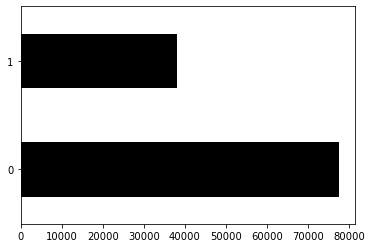

In [366]:
print(sampled_df.redemption_status.value_counts()/len(sampled_df))
sampled_df.redemption_status.value_counts().plot.barh(color='black')

In [367]:
sampled_df.reset_index(inplace=True)

sampled_df.drop('index',1,inplace=True)

sampled_df.head()

,coupon_id,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days,redemption_status,age_range,campaign_type,income_bracket,family_size
0,27,0.140786,0.176138,-0.012769,-1.009014,-0.500611,0.023466,-0.075422,0.179881,0.071213,0.711921,-0.550822,0.128690,-0.632939,-0.326890,1.657423,-2.301653,-0.974887,-1.463804,-0.218125,-0.886250,-0.454133,-1.034965,0.485674,-0.445016,0.196794,0.362643,1,0,0,0,1
1,21,13.127085,0.254461,0.214806,0.320264,-0.513376,0.766882,1.871571,10.970645,5.074854,12.170489,-9.673734,12.970719,-8.840455,12.675485,3.492056,-2.901284,0.464190,-1.172686,-0.086477,0.234918,0.020889,0.561139,-1.503021,-3.489735,3.740272,0.362643,1,0,0,1,3
2,942,-0.063963,-0.440354,-0.375273,0.154080,-0.453172,-0.273013,-0.090874,-0.031898,-0.051110,1.181770,-0.863239,-0.077562,0.052796,-1.004232,1.886459,-1.545806,0.025021,0.400206,0.210088,0.443574,0.168554,0.210015,0.223053,-1.391593,1.515899,0.362643,1,1,0,3,1
3,530,-0.053076,0.122062,-0.439150,0.144347,-0.357146,1.426728,-0.090874,-0.064390,-0.102353,-0.083946,0.146162,-0.069461,0.011367,0.059571,-0.177061,0.225075,-0.481011,-1.645474,-0.586137,-0.683641,-0.581181,-0.629756,-0.372040,0.314570,-0.268772,0.362643,1,0,0,1,0
4,754,-0.011624,-0.167432,-0.567409,-1.576839,-0.220058,-0.289498,-0.090874,0.003374,0.001787,0.448230,-0.734874,-0.040666,-0.340676,-0.780873,2.153218,-1.765070,-0.225716,-2.299838,3.252146,1.554144,2.457957,0.326597,-1.175298,-1.257869,1.386575,0.525360,1,1,0,0,2


In [369]:
# splitting the data training,validation and testing 
from sklearn.model_selection import train_test_split
x=sampled_df.drop(['redemption_status'],1)
y=sampled_df.redemption_status
xtrain_resample,xtest,ytrain_resample,ytest=train_test_split(x,y,test_size=0.3,stratify=y)

In [371]:
df_enc.head()


,coupon_id,Trans_count,avg_coup_dis,avg_order_quantity,avg_oth_dis,avg_price,avg_total_dis,count_brands,customer_count,count_items,sum_coup_count,sum_coup_dis,sum_order_quantity,sum_oth_dis,sum_total_dis,avg_coup_count_cust,avg_coup_disc_cust,count_items_cust,avg_oth_disc_cust,avg_quantity_cust,avg_price_cust,sum_quantity_cust,sum_price_cust,sum_oth_disc_cust,sum_coupp_disc_cust,count_coup_used_cust,campaigning_days,redemption_status,age_range,campaign_type,income_bracket,family_size
0,27,0.140786,0.176138,-0.012769,-1.009014,-0.500611,0.023466,-0.075422,0.179881,0.071213,0.711921,-0.550822,0.128690,-0.632939,-0.326890,-0.440592,0.305052,-1.097975,-1.718802,0.982589,2.161641,-0.147977,-0.757737,0.625393,0.455543,-0.449826,0.362643,0,0,0,0,0
1,116,-0.163867,0.389675,-0.461816,0.519925,-0.649456,-0.098358,-0.090874,-0.162888,-0.130454,-0.203806,0.197203,-0.160847,0.154508,-0.079091,0.485985,-2.345483,-0.984004,-1.087632,-0.446425,3.744679,-0.534847,-0.354027,0.596124,-0.444733,-0.165313,0.362643,0,1,0,1,1
2,635,-0.158256,-0.124061,0.682610,-4.387947,1.284872,-1.008540,-0.090874,-0.154546,-0.024662,-0.131890,0.112536,-0.153506,0.074390,-0.157044,2.358174,-1.437502,-0.095029,0.055159,-0.585870,0.161218,-0.579545,-0.020984,0.090370,-1.156285,1.722817,-2.078113,0,0,1,2,1
3,644,-0.166882,-0.376031,-0.237131,0.730284,-0.430078,-0.791605,-0.090874,-0.169767,-0.128801,-0.199011,0.194713,-0.163316,0.155819,-0.086880,-0.267731,-0.115208,-1.208907,0.186717,-0.586340,-0.561426,-0.583873,-1.170788,1.111016,0.385754,-0.423961,0.362643,0,2,0,0,1
4,1017,-0.051234,0.355615,-0.385799,-0.335091,0.199762,0.576397,-0.090874,-0.043900,-0.082517,-0.093535,0.117517,-0.064398,-0.035496,0.033101,0.042469,0.138213,-0.715032,-0.259756,0.552219,0.146701,-0.009180,-0.627376,0.529377,0.317642,-0.217043,0.525360,0,0,0,1,1


In [372]:
len(df_enc.columns)

32

### Base Models


LogisticRegression

In [373]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,recall_score,f1_score,precision_score,roc_auc_score,roc_curve
ypred_log=LogisticRegression().fit(xtrain_resample,ytrain_resample).predict(xtest)
print(accuracy_score(ytest,ypred_log))
print(roc_auc_score(ytest,ypred_log))
print(confusion_matrix(ytest,ypred_log))
print(classification_report(ytest,ypred_log))

0.8090584097330334
0.7612327149360131
[[20976  2310]
 [ 4313  7087]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     23286
           1       0.75      0.62      0.68     11400

    accuracy                           0.81     34686
   macro avg       0.79      0.76      0.77     34686
weighted avg       0.80      0.81      0.80     34686



In [374]:
accuracy=accuracy_score(ytest,ypred_log)
precision=precision_score(ytest,ypred_log)
recall=recall_score(ytest,ypred_log)
f1score=f1_score(ytest,ypred_log)
AUC=roc_auc_score(ytest,ypred_log)

In [375]:
result=pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','F1_Score','AUC'])
data=pd.Series({'Model':'LogisticRegression','Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1score,'AUC':AUC})
result=result.append(data,ignore_index=True)
result

,Model,Accuracy,Precision,Recall,F1_Score,AUC
0,LogisticRegression,0.809058,0.754177,0.621667,0.681541,0.761233


The recall/F1-scores are low, Hence the model is Bad

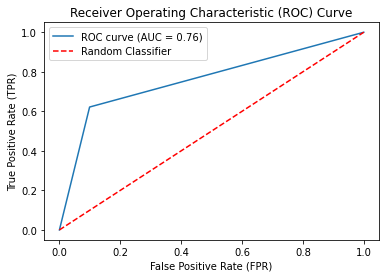

In [376]:
fpr, tpr, thresholds = roc_curve(ytest, ypred_log)
# Compute AUC-ROC score
auc = roc_auc_score(ytest, ypred_log)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')  # Plot random classifier for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

DecisionTreeClassifier

In [377]:
from sklearn.tree import DecisionTreeClassifier
ypred_dt=DecisionTreeClassifier().fit(xtrain_resample,ytrain_resample).predict(xtest)
print(accuracy_score(ytest,ypred_dt))
print(confusion_matrix(ytest,ypred_dt))
print(classification_report(ytest,ypred_dt))

accuracy=accuracy_score(ytest,ypred_dt)
precision=precision_score(ytest,ypred_dt)
recall=recall_score(ytest,ypred_dt)
f1score=f1_score(ytest,ypred_dt)
AUC=roc_auc_score(ytest,ypred_dt)

data=pd.Series({'Model':'DecisionTree','Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1score,'AUC':AUC})
result=result.append(data,ignore_index=True)
result

0.9935420630802053
[[23062   224]
 [    0 11400]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     23286
           1       0.98      1.00      0.99     11400

    accuracy                           0.99     34686
   macro avg       0.99      1.00      0.99     34686
weighted avg       0.99      0.99      0.99     34686



,Model,Accuracy,Precision,Recall,F1_Score,AUC
0,LogisticRegression,0.809058,0.754177,0.621667,0.681541,0.761233
1,DecisionTree,0.993542,0.98073,1.0,0.990271,0.99519


- **<u>_The Recall and accuracy Scores are very high, it performs well but might fail in future_</u>**
- **<u>_As the DecisionTree is a Greedy model it goes untill it gets the best scores_</u>**

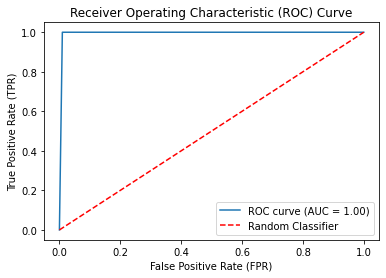

In [379]:
fpr, tpr, thresholds = roc_curve(ytest, ypred_dt)
# Compute AUC-ROC score
auc = roc_auc_score(ytest, ypred_dt)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')  # Plot random classifier for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

- <u>RandomForestClassifier</u>

In [380]:
from sklearn.ensemble import RandomForestClassifier
ypred_rf=RandomForestClassifier().fit(xtrain_resample,ytrain_resample).predict(xtest)
print(accuracy_score(ytest,ypred_rf))
print(confusion_matrix(ytest,ypred_rf))
print(classification_report(ytest,ypred_rf))

accuracy=accuracy_score(ytest,ypred_rf)
precision=precision_score(ytest,ypred_rf)
recall=recall_score(ytest,ypred_rf)
f1score=f1_score(ytest,ypred_rf)
AUC=roc_auc_score(ytest,ypred_rf)

data=pd.Series({'Model':'RandomForest','Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1score,'AUC':AUC})
result=result.append(data,ignore_index=True)
result

0.9981837052413077
[[23223    63]
 [    0 11400]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23286
           1       0.99      1.00      1.00     11400

    accuracy                           1.00     34686
   macro avg       1.00      1.00      1.00     34686
weighted avg       1.00      1.00      1.00     34686



,Model,Accuracy,Precision,Recall,F1_Score,AUC
0,LogisticRegression,0.809058,0.754177,0.621667,0.681541,0.761233
1,DecisionTree,0.993542,0.98073,1.0,0.990271,0.99519
2,RandomForest,0.998184,0.994504,1.0,0.997244,0.998647


- **<u>_The Recall and accuracy Scores are very high, it performs well but might fail in future_</u>**
- **<u>_As the RandomForest is certain number of DecisionTrees same happening here_</u>**

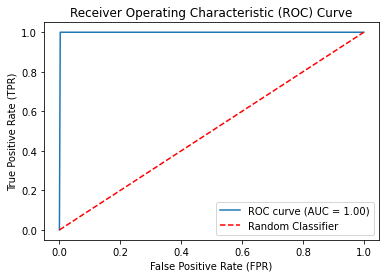

In [381]:
fpr, tpr, thresholds = roc_curve(ytest, ypred_rf)
# Compute AUC-ROC score
auc = roc_auc_score(ytest, ypred_rf)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')  # Plot random classifier for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

- <u>HyperParameter Tuning</u>

In [383]:
from sklearn.model_selection import GridSearchCV
dt=DecisionTreeClassifier()
params=({'criterion':['gini','entropy'],
         'max_depth':[10,12],
         'min_samples_split':[50],
         'min_samples_leaf': [2]
})
gridsearchcv=GridSearchCV(dt,params,cv=5)
gridsearchcv.fit(xtrain_resample,ytrain_resample)
print(gridsearchcv.best_params_)
print(gridsearchcv.best_score_)

{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 50}
0.9605965191621515


In [384]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(criterion= 'entropy', max_depth= 12, min_samples_leaf= 2, min_samples_split= 50)
ypred_dt=dt.fit(xtrain_resample,ytrain_resample).predict(xtest)
print(accuracy_score(ytest,ypred_dt))
print(confusion_matrix(ytest,ypred_dt))
print(classification_report(ytest,ypred_dt))

accuracy=accuracy_score(ytest,ypred_dt)
precision   =precision_score(ytest,ypred_dt)
recall     =recall_score(ytest,ypred_dt)
f1score=f1_score(ytest,ypred_dt)
AUC=roc_auc_score(ytest,ypred_dt)

data=pd.Series({'Model':'DT-GridSearchCV','Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1score,'AUC':AUC})
result=result.append(data,ignore_index=True)
result

0.9319898518134118
[[21406  1880]
 [  479 10921]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     23286
           1       0.85      0.96      0.90     11400

    accuracy                           0.93     34686
   macro avg       0.92      0.94      0.93     34686
weighted avg       0.94      0.93      0.93     34686



,Model,Accuracy,Precision,Recall,F1_Score,AUC
0,LogisticRegression,0.809058,0.754177,0.621667,0.681541,0.761233
1,DecisionTree,0.993542,0.98073,1.0,0.990271,0.99519
2,RandomForest,0.998184,0.994504,1.0,0.997244,0.998647
3,DT-GridSearchCV,0.93199,0.853136,0.957982,0.902525,0.938624


- **<u>_After pruning the performance is improved and Auc is also more _</u>**

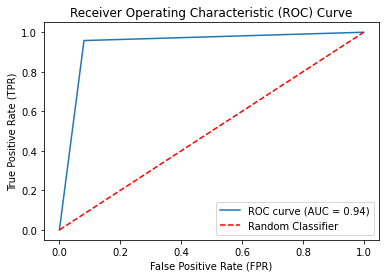

In [385]:
fpr, tpr, thresholds = roc_curve(ytest, ypred_dt)
# Compute AUC-ROC score
auc = roc_auc_score(ytest, ypred_dt)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')  # Plot random classifier for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

- <u>AdaBoost</u>

In [386]:
from sklearn.ensemble import AdaBoostClassifier
ypred_ab=AdaBoostClassifier().fit(xtrain_resample,ytrain_resample).predict(xtest)
print(accuracy_score(ytest,ypred_ab))
print(confusion_matrix(ytest,ypred_ab))
print(classification_report(ytest,ypred_ab))

accuracy=accuracy_score(ytest,ypred_ab)
precision=precision_score(ytest,ypred_ab)
recall=recall_score(ytest,ypred_ab)
f1score=f1_score(ytest,ypred_ab)
AUC=roc_auc_score(ytest,ypred_ab)

data=pd.Series({'Model':'AdaBoost','Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1score,'AUC':AUC})
result=result.append(data,ignore_index=True)
result

0.8783659113186877
[[20956  2330]
 [ 1889  9511]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     23286
           1       0.80      0.83      0.82     11400

    accuracy                           0.88     34686
   macro avg       0.86      0.87      0.86     34686
weighted avg       0.88      0.88      0.88     34686



,Model,Accuracy,Precision,Recall,F1_Score,AUC
0,LogisticRegression,0.809058,0.754177,0.621667,0.681541,0.761233
1,DecisionTree,0.993542,0.98073,1.0,0.990271,0.99519
2,RandomForest,0.998184,0.994504,1.0,0.997244,0.998647
3,DT-GridSearchCV,0.93199,0.853136,0.957982,0.902525,0.938624
4,AdaBoost,0.878366,0.803226,0.834298,0.818467,0.867119


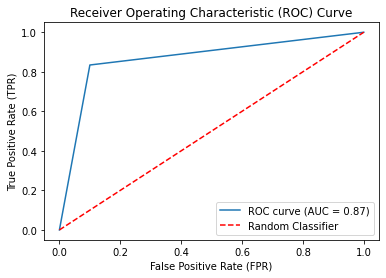

In [387]:
fpr, tpr, thresholds = roc_curve(ytest, ypred_ab)
# Compute AUC-ROC score
auc = roc_auc_score(ytest, ypred_ab)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')  # Plot random classifier for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [388]:
ad=AdaBoostClassifier()
tuned_params =[{'n_estimators':[200],'learning_rate':[0.5,0.6]}]
ad_tuned= GridSearchCV(estimator=ad,param_grid=tuned_params,cv=2,n_jobs=-1)
ad_tuned.fit(xtrain_resample,ytrain_resample)

ad_tuned.best_params_

{'learning_rate': 0.6, 'n_estimators': 200}

In [389]:
ypred_ab=AdaBoostClassifier(learning_rate= 0.6, n_estimators= 200).fit(xtrain_resample,ytrain_resample).predict(xtest)
print(accuracy_score(ytest,ypred_ab))
print(confusion_matrix(ytest,ypred_ab))
print(classification_report(ytest,ypred_ab))

accuracy=accuracy_score(ytest,ypred_ab)
precision=precision_score(ytest,ypred_ab)
recall=recall_score(ytest,ypred_ab)
f1score=f1_score(ytest,ypred_ab)
AUC=roc_auc_score(ytest,ypred_ab)

data=pd.Series({'Model':'AdaBoost-Tuned','Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1score,'AUC':AUC})
result=result.append(data,ignore_index=True)
result

0.8917142362912991
[[21118  2168]
 [ 1588  9812]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     23286
           1       0.82      0.86      0.84     11400

    accuracy                           0.89     34686
   macro avg       0.87      0.88      0.88     34686
weighted avg       0.89      0.89      0.89     34686



,Model,Accuracy,Precision,Recall,F1_Score,AUC
0,LogisticRegression,0.809058,0.754177,0.621667,0.681541,0.761233
1,DecisionTree,0.993542,0.98073,1.0,0.990271,0.99519
2,RandomForest,0.998184,0.994504,1.0,0.997244,0.998647
3,DT-GridSearchCV,0.93199,0.853136,0.957982,0.902525,0.938624
4,AdaBoost,0.878366,0.803226,0.834298,0.818467,0.867119
5,AdaBoost-Tuned,0.891714,0.819032,0.860702,0.83935,0.883799


- **<u>_Adaboost-Tuned is perfoming better than normal Adaboost model_<u/>**

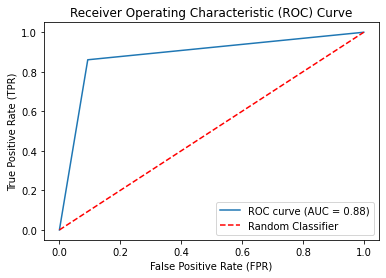

In [390]:
fpr, tpr, thresholds = roc_curve(ytest, ypred_ab)
# Compute AUC-ROC score
auc = roc_auc_score(ytest, ypred_ab)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')  # Plot random classifier for reference
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()